In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
from sklearn.datasets import load_iris
from linearmodels.iv import IV2SLS
from statsmodels.formula.api import quantreg, wls
from statsmodels.iolib.summary2 import summary_col
from PIL import Image
from statsmodels.stats.stattools import durbin_watson
from collections import OrderedDict
from linearmodels.iv.results import compare
import doubleml as dml
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from doubleml import DoubleMLData, DoubleMLClusterData, DoubleMLPLIV
from doubleml.utils import DMLDummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import holidays
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LassoCV

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-it0cvlhc because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()


In [3]:
import os
os.environ["OMP_NUM_THREADS"] = "4"  # or "8" depending on your CPU


In [4]:
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {'MAE': mae, 'RMSE': rmse, 'R²': r2}

def print_metrics(metrics, dataset_type):
    print(f"{dataset_type} Metrics:")
    print(f"  MAE: {metrics['MAE']:.4f}")
    print(f"  RMSE: {metrics['RMSE']:.4f}")
    print(f"  R²: {metrics['R²']:.4f}")

def evaluate_predictions(predictions, true_values, target_name="TargetVariable", time_values=None):
    """
    Evaluate model predictions against true values with metrics and visualizations.

    Args:
        predictions (pd.Series or np.ndarray): Model's predicted values.
        true_values (pd.Series or np.ndarray): True values from the dataset.
        target_name (str): Name of the target variable (for labeling plots and messages).
        time_values (pd.Series): Time values corresponding to the data for coloring.

    Returns:
        dict: Dictionary of metrics including MAE, RMSE, R², and percentage errors.
    """
    # Ensure inputs are aligned
    if isinstance(predictions, np.ndarray):
        predictions = pd.Series(predictions, index=true_values.index)
    
    # Calculate metrics
    metrics = calculate_metrics(true_values, predictions)
    
    # Print metrics
    print_metrics(metrics, dataset_type=f"Test - {target_name}")
    
    # Range of the target variable
    target_min = true_values.min()
    target_max = true_values.max()
    target_range = target_max - target_min
    print(f"{target_name} Range: Min = {target_min}, Max = {target_max}, Range = {target_range}")
    
    # Percentage errors
    mae_percentage = (metrics['MAE'] / target_range) * 100
    rmse_percentage = (metrics['RMSE'] / target_range) * 100
    
    print(f"MAE as percentage of range: {mae_percentage:.2f}%")
    print(f"RMSE as percentage of range: {rmse_percentage:.2f}%")
    
    # Extract years for coloring
    if time_values is not None:
        unique_years = time_values.unique()
        norm = mcolors.Normalize(vmin=min(unique_years), vmax=max(unique_years))
        cmap = cm.viridis
        colors = cmap(norm(time_values))
    else:
        colors = 'blue'  # Default color if no time_values provided
    
    # Visualizations
    # Scatter plot: Predicted vs Actual
    plt.scatter(true_values, predictions, c=colors, alpha=0.6)
    plt.plot([target_min, target_max], [target_min, target_max], 'r--', label='Perfect prediction')  # Perfect prediction line
    plt.title(f'Predicted vs. Actual {target_name}')
    plt.xlabel(f'Actual {target_name}')
    plt.ylabel(f'Predicted {target_name}')
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label='Year')
    plt.legend()
    plt.show()
    
    # Residuals plot
    residuals = true_values - predictions
    plt.scatter(true_values, residuals, c=colors, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
    plt.title(f'Residuals vs. Actual {target_name}')
    plt.xlabel(f'Actual {target_name}')
    plt.ylabel('Residuals')
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label='Year')
    plt.legend()
    plt.show()
    
    # Return metrics and percentages
    return {
        "Metrics": metrics,
        "MAE_Percentage": mae_percentage,
        "RMSE_Percentage": rmse_percentage
    }

In [5]:
def evaluate_predictions_country(predictions, true_values, target_name="TargetVariable", country_values=None, title="Country"):
    """
    Evaluate model predictions against true values with metrics and visualizations.

    Args:
        predictions (pd.Series or np.ndarray): Model's predicted values.
        true_values (pd.Series or np.ndarray): True values from the dataset.
        target_name (str): Name of the target variable (for labeling plots and messages).
        country_values (pd.Series or np.ndarray): Country values corresponding to the data for coloring.

    Returns:
        dict: Dictionary of metrics including MAE, RMSE, R², and percentage errors.
    """
    import random
    from matplotlib.colors import ListedColormap

    # Ensure inputs are aligned
    if isinstance(predictions, np.ndarray):
        predictions = pd.Series(predictions, index=true_values.index)
    
    # Calculate metrics
    metrics = calculate_metrics(true_values, predictions)
    
    # Print metrics
    print_metrics(metrics, dataset_type=f"Test - {target_name}")
    
    # Range of the target variable
    target_min = true_values.min()
    target_max = true_values.max()
    target_range = target_max - target_min
    print(f"{target_name} Range: Min = {target_min}, Max = {target_max}, Range = {target_range}")
    
    # Percentage errors
    mae_percentage = (metrics['MAE'] / target_range) * 100
    rmse_percentage = (metrics['RMSE'] / target_range) * 100
    
    print(f"MAE as percentage of range: {mae_percentage:.2f}%")
    print(f"RMSE as percentage of range: {rmse_percentage:.2f}%")
    
    # Generate distinct colors for each unique country
    if country_values is not None:
        unique_countries = np.unique(country_values)
        num_countries = len(unique_countries)
        
        # Generate a list of random, unique colors
        random.seed(42)  # Ensures reproducibility
        colors = [
            (random.random(), random.random(), random.random()) 
            for _ in range(num_countries)
        ]
        cmap = ListedColormap(colors)
        
        # Map each country to a unique color
        color_mapping = {country: colors[idx] for idx, country in enumerate(unique_countries)}
        dot_colors = [color_mapping[country] for country in country_values]
    else:
        dot_colors = 'blue'  # Default color if no country_values provided
        color_mapping = None
    
    # Visualizations
    # Scatter plot: Predicted vs Actual
    plt.figure(figsize=(10, 6))
    plt.scatter(true_values, predictions, c=dot_colors, alpha=0.6)
    plt.plot([target_min, target_max], [target_min, target_max], 'r--', label='Perfect prediction')  # Perfect prediction line
    plt.title(f'Predicted vs. Actual {target_name}')
    plt.xlabel(f'Actual {target_name}')
    plt.ylabel(f'Predicted {target_name}')
    if country_values is not None:
        handles = [
            plt.Line2D([0], [0], marker='o', color=color_mapping[country], linestyle='', label=country)
            for country in unique_countries
        ]
        plt.legend(handles=handles, title=title, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    
    # Residuals plot
    plt.figure(figsize=(10, 6))
    residuals = true_values - predictions
    plt.scatter(true_values, residuals, c=dot_colors, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
    plt.title(f'Residuals vs. Actual {target_name}')
    plt.xlabel(f'Actual {target_name}')
    plt.ylabel('Residuals')
    if country_values is not None:
        plt.legend(handles=handles, title=title, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    
    # Return metrics and percentages
    return {
        "Metrics": metrics,
        "MAE_Percentage": mae_percentage,
        "RMSE_Percentage": rmse_percentage
    }

In [6]:
def prepare_data_with_dummies_and_interactions(
    data,
    base_covariates=None,
    include_interactions=None,
    dependent_variable='consumption_normalized',
    include_lags=True  # 👈 New flag to include/exclude lags
):
    data = data.copy()
    data = data[data["PriceArea"] != "DE_AT_LU"]
    data['Time'] = pd.to_datetime(data['Time'])
    data['Year'] = data['Time'].dt.year
    data = data.sort_values(by='Time')
    data['Country'] = data['PriceArea']
    data['consumption_normalized'] = (
        data['ConsumptionValue'] / 
        data.groupby(['Country', data['Time'].dt.year])['ConsumptionValue'].transform('mean')
    )
    data['consumption_norm_peak'] = (
        data['ConsumptionValue'] / 
        data.groupby(['Country', 'Year'])['ConsumptionValue'].transform('max')
    )

    data['Total_Wind_Generation'] = (
        data['Wind_Offshore'].fillna(0) + data['Wind_Onshore'].fillna(0)
    )

    # Dummies
    data = pd.get_dummies(data, columns=['block'], drop_first=False)
    data = pd.get_dummies(data, columns=['PriceArea'], drop_first=False)
    price_area_columns = [col for col in data.columns if col.startswith('PriceArea_')]
    for col in price_area_columns:
        data[col] = data[col].astype(int)

    data['HourOfWeek'] = data['Time'].dt.dayofweek * 24 + data['Time'].dt.hour
    data = pd.get_dummies(data, columns=['HourOfWeek'], drop_first=False)

    data['Month'] = data['Time'].dt.month
    data = pd.get_dummies(data, columns=['Month'], drop_first=False)

    # Rolling features
    data['RollingMean24h'] = (
        data.groupby(['Country', 'Year'])[dependent_variable]
        .transform(lambda x: x.rolling(window=24, min_periods=12).mean())
    )
    data['RollingStd24h_Price'] = (
        data.groupby(['Country', 'Year'])['DayAheadPriceEUR']
        .transform(lambda x: x.rolling(window=24, min_periods=12).std())
    )

    # Weekend / spike flags
    data['IsWeekend'] = (data['Time'].dt.dayofweek >= 5).astype(int)
    price_threshold = data['DayAheadPriceEUR'].quantile(0.95)
    data['PriceSpike'] = (data['DayAheadPriceEUR'] > price_threshold).astype(int)

    # Step 2: Add interaction terms if specified
    interaction_covariates = []
    block_dummy_columns = [col for col in data.columns if col.startswith('block_')]

    if include_interactions:
        for block_col in block_dummy_columns:
            if 'block' in include_interactions:
                for interaction_col in include_interactions['block']:
                    interaction_term = f'{block_col}:{interaction_col}'
                    data[interaction_term] = data[block_col] * data[interaction_col]
                    interaction_covariates.append(interaction_term)

    # Step 3: Optionally add lagged features
    lag_features = []
    if include_lags:
        data['Lag1_Consumption'] = data.groupby('Country')[dependent_variable].shift(1)
        data['Lag24_Consumption'] = data.groupby('Country')[dependent_variable].shift(24)
        data['Lag168_Consumption'] = data.groupby('Country')[dependent_variable].shift(168)
        lag_features = ['Lag1_Consumption', 'Lag24_Consumption', 'Lag168_Consumption']

    # Step 4: Define covariates
    if base_covariates is None:
        base_covariates = []

    engineered_features = ['RollingMean24h', 'RollingStd24h_Price', 'IsWeekend', 'PriceSpike']
    all_features = base_covariates + engineered_features + lag_features

    for feat in all_features:
        if feat not in base_covariates:
            base_covariates.append(feat)

    covariates = list(set(base_covariates + interaction_covariates +
                          [col for col in data.columns if col.startswith('PriceArea_')] +
                          [col for col in data.columns if col.startswith('HourOfWeek_')] +
                          [col for col in data.columns if col.startswith('Month_')]))

    covariates = [col for col in covariates if not (col.startswith('block_') and ':' not in col)]

    # Drop NaNs from rolling/lags
    data = data.dropna()

    return data, covariates

In [7]:
def prepare_data_lags_with_iv_lags(
    data,
    base_covariates=None,
    include_interactions=None,
    dependent_variable='consumption_normalized',
    include_lags=True,
    lag_variable='Total_Wind_Generation',
    n_lags=50
):
    data = data.copy()
    data = data[data["PriceArea"] != "DE_AT_LU"]
    data['Time'] = pd.to_datetime(data['Time'])
    data['Year'] = data['Time'].dt.year
    data = data.sort_values(by='Time')
    data['Country'] = data['PriceArea']
    data['consumption_normalized'] = (
        data['ConsumptionValue'] / 
        data.groupby(['Country', data['Time'].dt.year])['ConsumptionValue'].transform('mean')
    )
    data['consumption_norm_peak'] = (
        data['ConsumptionValue'] / 
        data.groupby(['Country', 'Year'])['ConsumptionValue'].transform('max')
    )

    data['Total_Wind_Generation'] = (
        data['Wind_Offshore'].fillna(0) + data['Wind_Onshore'].fillna(0)
    )

    # Dummies
    data = pd.get_dummies(data, columns=['block'], drop_first=False)
    data = pd.get_dummies(data, columns=['PriceArea'], drop_first=False)
    price_area_columns = [col for col in data.columns if col.startswith('PriceArea_')]
    for col in price_area_columns:
        data[col] = data[col].astype(int)

    data['HourOfWeek'] = data['Time'].dt.dayofweek * 24 + data['Time'].dt.hour
    data = pd.get_dummies(data, columns=['HourOfWeek'], drop_first=False)

    data['Month'] = data['Time'].dt.month
    data = pd.get_dummies(data, columns=['Month'], drop_first=False)

    # Rolling features
    data['RollingMean24h'] = (
        data.groupby(['Country', 'Year'])[dependent_variable]
        .transform(lambda x: x.rolling(window=24, min_periods=12).mean())
    )
    data['RollingStd24h_Price'] = (
        data.groupby(['Country', 'Year'])['DayAheadPriceEUR']
        .transform(lambda x: x.rolling(window=24, min_periods=12).std())
    )

    # Weekend / spike flags
    data['IsWeekend'] = (data['Time'].dt.dayofweek >= 5).astype(int)

    # Step 2: Add interaction terms if specified
    interaction_covariates = []
    block_dummy_columns = [col for col in data.columns if col.startswith('block_')]

    if include_interactions:
        for block_col in block_dummy_columns:
            if 'block' in include_interactions:
                for interaction_col in include_interactions['block']:
                    interaction_term = f'{block_col}:{interaction_col}'
                    data[interaction_term] = data[block_col] * data[interaction_col]
                    interaction_covariates.append(interaction_term)

    # Step 3: Add lagged instruments
    lagged_iv_columns = []
    if include_lags:
        for lag in range(1, n_lags + 1):
            lag_col = f'{lag_variable}_lag{lag}'
            data[lag_col] = (
                data.groupby('Country')[lag_variable]
                .transform(lambda x: x.shift(lag))
            )
            lagged_iv_columns.append(lag_col)

    # Create full covariate list
    covariates = list(set(base_covariates + interaction_covariates +
                          [col for col in data.columns if col.startswith('PriceArea_')] +
                          [col for col in data.columns if col.startswith('HourOfWeek_')] +
                          [col for col in data.columns if col.startswith('Month_')] +
                          lagged_iv_columns))

    covariates = [col for col in covariates if not (col.startswith('block_') and ':' not in col)]
    endogenous_variable = 'DayAheadPriceEUR'
    instrument_variables = ['Total_Wind_Generation']

    key_variables = [dependent_variable, endogenous_variable] + instrument_variables + covariates
    filtered_processed_data = data.dropna(subset=key_variables)

    return filtered_processed_data, covariates

In [8]:
def dml_rolling_window(filtered_data, base_covariates, manual_params_l=None, manual_params_r = None, manual_params_m=None, param_dist_xgb=None, param_dist_xgb_r=None, param_dist_xgb_m=None, dependent_variable = 'consumption_normalized'):
    
    data = filtered_data.copy()
    
    covariates = base_covariates.copy()
    

    # Initialize lists to collect predictions and time indices
    predictions_ml_l = []
    predictions_ml_r = []
    predictions_ml_m = []
    time_indices = []
    train_predictions = []
    train_actuals = []
    test_predictions = []
    test_actuals = []
    feature_importances_per_window = []
    fold_metrics = []
    test_years = []
    fold_feature_importance_df = []
    fold_coefficients = []

    

    train_test_pairs = [
    (2015, 2016, 2017),
    (2016, 2017, 2018),
    (2017, 2018, 2019),
    (2018, 2019, 2020),
    (2019, 2020, 2021),
    (2020, 2021, 2022),
    (2021, 2022, 2023),
    (2022, 2023, 2024)]
    
    
    def tune_xgb_model(X, y, param_dist_xgb):
        tscv = TimeSeriesSplit(n_splits=3)
        model = xgb.XGBRegressor(objective="reg:squarederror", tree_method="hist", eval_metric="rmse")
        grid_search = GridSearchCV(model, param_dist_xgb, cv=tscv, n_jobs=-1)
        grid_search.fit(X, y)
        return grid_search.best_params_
        
    best_params_xgb = None  # Store best params from first window
    best_params_xgb_treat = None
    best_params_xgb_inst = None
    lasso_param = None
    
    data['Year'] = data['Time'].dt.year
    year_to_indices = data.groupby('Year').indices

    
    
    for train_start, train_end, test_year in train_test_pairs:
        train_indices = []
        for y in range(train_start, train_end + 1):
            if y in year_to_indices:
                train_indices.extend(year_to_indices[y])

        test_indices = year_to_indices.get(test_year, [])

        if len(train_indices) == 0 or len(test_indices) == 0:
            print(f"Skipping test year {test_year} due to insufficient data.")
            continue
        
        train_data = data.iloc[train_indices]
        test_data = data.iloc[test_indices]



        print(f"\nTest Year: {test_year} | Training Years: {train_start} to {train_end}")
        print(f"Train samples: {len(train_indices)} | Test samples: {len(test_indices)}")


        X_train = train_data[covariates]
        y_train_ml_l = train_data[dependent_variable]
        d_train_ml_r = train_data['DayAheadPriceEUR']
        z_train_ml_m_1 = train_data['Total_Wind_Generation']
        
        
        if best_params_xgb is None and manual_params_l is None:
            best_params_xgb = tune_xgb_model(X_train, y_train_ml_l, param_dist_xgb)
            print("Best L Parameters:", best_params_xgb)
        
        if best_params_xgb_treat is None and manual_params_r is None:
            best_params_xgb_treat = tune_xgb_model(X_train, d_train_ml_r, param_dist_xgb_r)
            print("Best R Parameters:", best_params_xgb_treat)
            
            
        if best_params_xgb_inst is None and manual_params_m is None:
            best_params_xgb_inst = tune_xgb_model(X_train, z_train_ml_m_1, param_dist_xgb_m)
            print("Best M Parameters:", best_params_xgb_inst)
            
        learner_l = xgb.XGBRegressor(**(manual_params_l if manual_params_l else best_params_xgb))
        learner_r = xgb.XGBRegressor(**(manual_params_r if manual_params_r else best_params_xgb_treat))
        learner_m = xgb.XGBRegressor(**(manual_params_m if manual_params_m else best_params_xgb_inst))
            # Train each model on the training set (fixed window)
        learner_l.fit(X_train, y_train_ml_l)
        learner_r.fit(X_train, d_train_ml_r)
        learner_m.fit(X_train, z_train_ml_m_1)
            
        feature_importances_per_window.append(learner_l.feature_importances_)

            # Predict on the test set (next year)
        X_test = test_data[covariates]
        y_test_ml_l = test_data[dependent_variable]
        d_test_ml_r = test_data['DayAheadPriceEUR']
        z_test_ml_m_1 = test_data['Total_Wind_Generation']
        pred_l = learner_l.predict(X_test)
        pred_r = learner_r.predict(X_test)
        pred_m = learner_m.predict(X_test)
            
            # Predict on the train set (next year)
        train_predictions.extend(learner_l.predict(X_train))
        train_actuals.extend(y_train_ml_l)
        test_predictions.extend(learner_l.predict(X_test))
        test_actuals.extend(y_test_ml_l)

            # Append predictions and indices to the lists
        predictions_ml_l.extend(pred_l)
        predictions_ml_r.extend(pred_r)
        predictions_ml_m.extend(pred_m)
        time_indices.extend(test_data.index.tolist())
        
        plt.figure(figsize=(12, 4))
        plt.plot(test_actuals[:500], label='Actual')
        plt.plot(test_predictions[:500], label='Predicted')
        plt.title("First 500 test predictions vs actuals")
        plt.legend()
        plt.show()
        
        fold_mae = mean_absolute_error(y_test_ml_l, pred_l)
        fold_rmse = mean_squared_error(y_test_ml_l, pred_l, squared=False)
        fold_r2 = r2_score(y_test_ml_l, pred_l)
        fold_rr = r2_score(d_test_ml_r, pred_r)
        fold_rz = r2_score(z_test_ml_m_1, pred_m)
        print("Test error l:", fold_r2)
        print("Test error r:", fold_rr)
        print("Test error m:", fold_rz)
        
        fold_metrics.append({
            'Test Year': test_year,
            'MAE': fold_mae,
            'RMSE': fold_rmse,
            'R2': fold_r2
        })
        test_years.append(test_year)
        
        fold_feature_importance_df.append(pd.DataFrame({
            'Feature': covariates,
            'Importance': learner_l.feature_importances_,
            'Year': test_year
        }))
        
        dml_data_fold = dml.DoubleMLClusterData(
            test_data.reset_index(drop=True),
            y_col=dependent_variable,
            d_cols='DayAheadPriceEUR',
            z_cols='Total_Wind_Generation',
            x_cols=covariates,
            cluster_cols=['Country']
        )
        
        dml_fold = dml.DoubleMLPLIV(dml_data_fold, dml.utils.DMLDummyRegressor(), dml.utils.DMLDummyRegressor(), dml.utils.DMLDummyRegressor())
        dml_fold.fit(external_predictions={
            'DayAheadPriceEUR': {
                'ml_l': pred_l.reshape(-1, 1),
                'ml_r': pred_r.reshape(-1, 1),
                'ml_m': pred_m.reshape(-1, 1)
            }
        })
        fold_coefficients.append({
            'Year': test_year,
            'coef': dml_fold.coef,
            'se': dml_fold.se,
            't': dml_fold.t_stat,
            'p': dml_fold.pval,
        })


    # Calculate metrics for the entire model
    train_mae = mean_absolute_error(train_actuals, train_predictions)
    train_rmse = mean_squared_error(train_actuals, train_predictions, squared=False)
    train_r2 = r2_score(train_actuals, train_predictions)

    test_mae = mean_absolute_error(test_actuals, test_predictions)
    test_rmse = mean_squared_error(test_actuals, test_predictions, squared=False)
    test_r2 = r2_score(test_actuals, test_predictions)

    print("Overall Train Metrics:")
    print(f"MAE: {train_mae}, RMSE: {train_rmse}, R²: {train_r2}")

    print("Overall Test Metrics:")
    print(f"MAE: {test_mae}, RMSE: {test_rmse}, R²: {test_r2}")

    
    
    feature_importances_array = np.array(feature_importances_per_window)
    mean_importances = feature_importances_array.mean(axis=0)
    std_importances = feature_importances_array.std(axis=0)
    importance_df = pd.DataFrame({
        'Feature': covariates,
        'Mean Importance': mean_importances,
        'Std Importance': std_importances
    }).sort_values(by='Mean Importance', ascending=False)
    

    # Convert predictions lists to numpy arrays
    filtered_data = data.loc[data.index.isin(time_indices)].copy()
    
    #### predictins dataset? original dataset?

    predictions_ml_l = np.array(predictions_ml_l).reshape(-1, 1)
    predictions_ml_r = np.array(predictions_ml_r).reshape(-1, 1)
    predictions_ml_m = np.array(predictions_ml_m).reshape(-1, 1)


    pred_dict = {
        'DayAheadPriceEUR': {
            'ml_l': predictions_ml_l,
            'ml_r': predictions_ml_r,
            'ml_m': predictions_ml_m
        }
    }

    # Initialize DoubleML data object
    obj_dml_data = dml.DoubleMLClusterData(
        filtered_data,
        y_col=dependent_variable,
        d_cols='DayAheadPriceEUR',
        z_cols='Total_Wind_Generation',  # Use original instruments (not the lags) for DoubleML
        x_cols=covariates,
        cluster_cols=['Country']
    )
    # Use dummy regressors for DoubleML
    ml_l = dml.utils.DMLDummyRegressor()
    ml_m = dml.utils.DMLDummyRegressor()
    ml_r = dml.utils.DMLDummyRegressor()

    # Initialize and fit DoubleML with external predictions
    dml_pliv_obj = dml.DoubleMLPLIV(obj_dml_data, ml_l, ml_m, ml_r)
    dml_pliv_obj.fit(external_predictions=pred_dict)

    print(dml_pliv_obj)
    filtered_data["Prrediction"] = dml_pliv_obj.predictions["ml_l"].ravel()
    filtered_data["Residuals"] = dml_pliv_obj.predictions["ml_l"].ravel() - filtered_data[dependent_variable]
    importance_all_folds_df = pd.concat(fold_feature_importance_df, ignore_index=True)
    fold_metrics_df = pd.DataFrame(fold_metrics)
    
    
    
    return dml_pliv_obj, filtered_data, importance_df, fold_metrics_df, importance_all_folds_df, fold_coefficients

In [9]:
data_1 = pd.read_csv('/workspace/new_data/filtered_data_with_holidays_updated.csv', index_col=0)
data_1

Unnamed: 0                 Time PriceArea  ConsumptionValue  \
Unnamed: 0.1                                                                
0.0                  0.0  2015-01-01 01:00:00        CH            7654.0   
1.0                 17.0  2015-01-01 01:00:00        SK            2728.0   
2.0                 16.0  2015-01-01 01:00:00        SI            1045.0   
3.0                 15.0  2015-01-01 01:00:00        PT            5124.0   
4.0                 10.0  2015-01-01 01:00:00      DK_2            1305.0   
...                  ...                  ...       ...               ...   
NaN                  NaN  2025-01-01 00:00:00      SE_2            1791.0   
NaN                  NaN  2025-01-01 00:00:00      SE_3            9658.0   
NaN                  NaN  2025-01-01 00:00:00      SE_4            2146.0   
NaN                  NaN  2025-01-01 00:00:00        SI            1159.0   
NaN                  NaN  2025-01-01 00:00:00        SK            2524.0   

              DayAheadPriceEUR  WeatherWindSpeed  WeatherTemperature    Year  \
Unnamed: 0.1                                                                   
0.0                      38.08          3.647062          267.706482  2015.0   
1.0                      22.06          3.991796          265.239655  2015.0   
2.0                      22.20          4.172168          265.189819  2015.0   
3.0                      47.33          6.417383          279.455658  2015.0   
4.0                      16.04         10.561893          276.635590  2015.0   
...                        ...               ...                 ...     ...   
NaN                       3.69          3.096981          262.690735  2025.0   
NaN                       2.47          7.332158          272.276581  2025.0   
NaN                       2.04         14.230573          276.445221  2025.0   
NaN                     129.07          3.418118          274.394440  2025.0   
NaN                     138.56          6.014961          268.740997  2025.0   

              Month  Day  ...         YearMonthDay  Price_Area  Price_gas  \
Unnamed: 0.1              ...                                               
0.0             1.0  1.0  ...           2015-01-01        cegh     20.650   
1.0             1.0  1.0  ...           2015-01-01          cz     20.650   
2.0             1.0  1.0  ...           2015-01-01        cegh     20.650   
3.0             1.0  1.0  ...           2015-01-01          cz     20.650   
4.0             1.0  1.0  ...           2015-01-01         etf     20.650   
...             ...  ...  ...                  ...         ...        ...   
NaN             1.0  1.0  ...  2025-01-01 00:00:00         etf     48.889   
NaN             1.0  1.0  ...  2025-01-01 00:00:00         etf     48.889   
NaN             1.0  1.0  ...  2025-01-01 00:00:00         etf     48.889   
NaN             1.0  1.0  ...  2025-01-01 00:00:00        cegh     48.889   
NaN             1.0  1.0  ...  2025-01-01 00:00:00          cz     48.889   

              Price_coal  Price_EUA IsHoliday  B16  B18     B19 Price_gas_ttf  
Unnamed: 0.1                                                                   
0.0                 66.7       7.34       1.0  NaN  NaN     NaN           NaN  
1.0                 66.7       7.34       1.0  NaN  NaN     NaN           NaN  
2.0                 66.7       7.34       1.0  NaN  NaN     NaN           NaN  
3.0                 66.7       7.34       1.0  NaN  NaN     NaN           NaN  
4.0                 66.7       7.34       1.0  NaN  NaN     NaN           NaN  
...                  ...        ...       ...  ...  ...     ...           ...  
NaN                114.5      73.00       NaN  0.0  NaN   243.0           NaN  
NaN                114.5      73.00       NaN  0.0  NaN  2131.0           NaN  
NaN                114.5      73.00       NaN  1.0  NaN  1849.0           NaN  
NaN                114.5      73.00       NaN  0.0  NaN     0.0           NaN  
NaN      

In [10]:
rows_to_remove = [
    ("2022-02-10 20:00:00", "SE_2"),
    ("2022-02-10 21:00:00", "SE_2"),
    ("2022-02-10 22:00:00", "SE_2"),
    ("2020-02-27 09:00:00", "DK_2"),
    ("2024-10-22 14:00:00", "DK_2"),
    ("2017-05-08 07:00:00", "DK_1"),
    ("2018-02-06 12:00:00", "DK_2"),
    ("2021-12-20 18:00:00", "IT_CALA"),
    ("2021-12-20 16:00:00", "IT_CALA"),
    ("2021-12-21 09:00:00", "IT_CALA"),
    ("2021-12-17 18:00:00", "IT_CALA"),
    ("2021-12-20 08:00:00", "IT_CALA"),
    ("2021-12-20 15:00:00", "IT_CALA"),
    ("2021-12-21 12:00:00", "IT_CALA"),
    ("2022-01-25 08:00:00", "IT_CALA"),
    ("2021-12-21 11:00:00", "IT_CALA"),
    ("2021-12-20 19:00:00", "IT_CALA"),
    ("2017-05-08 06:00:00", "DK_1"),
    ("2021-12-21 08:00:00", "IT_CALA"),
    ("2021-11-29 16:00:00", "IT_CALA"),
    ("2021-12-17 16:00:00", "IT_CALA")
]
data_1['Time'] = pd.to_datetime(data_1['Time'])
for time_str, country in rows_to_remove:
    timestamp = pd.to_datetime(time_str)
    data_1 = data_1[~((data_1['Time'] == timestamp) & (data_1['PriceArea'] == country))]

In [13]:
def prepare_data_lags_with_iv_lags(
    data,
    base_covariates=None,
    include_interactions=None,
    dependent_variable='consumption_normalized',
    include_lags=True,
    lag_variable='log_Total_Wind_Generation',
    n_lags=50,
    apply_log_transform = True 
):
    data = data.copy()
    data = data[data["PriceArea"] != "DE_AT_LU"]
    data['Time'] = pd.to_datetime(data['Time'])
    data['Year'] = data['Time'].dt.year
    data = data.sort_values(by='Time')
    data['Country'] = data['PriceArea']
    data['consumption_normalized'] = (
        data['ConsumptionValue'] / 
        data.groupby(['Country', data['Time'].dt.year])['ConsumptionValue'].transform('mean')
    )
    data['consumption_norm_peak'] = (
        data['ConsumptionValue'] / 
        data.groupby(['Country', 'Year'])['ConsumptionValue'].transform('max')
    )

    data['Total_Wind_Generation'] = (
        data['Wind_Offshore'].fillna(0) + data['Wind_Onshore'].fillna(0)
    )
    
    if apply_log_transform:
        log_vars = [
            'consumption_normalized', 'DayAheadPriceEUR',
            'Total_Wind_Generation', 
            'Price_gas', 'Price_coal', 'Price_EUA', 'Solar_MWh'
        ]
        epsilon = 1e-3

        # Apply log transformation
        data['log_consumption'] = np.log(data['consumption_normalized'].clip(lower=epsilon))
        data['log_DayAheadPriceEUR'] = np.log(data['DayAheadPriceEUR'].clip(lower=epsilon))
        data['log_Total_Wind_Generation'] = np.log(data['Total_Wind_Generation'].clip(lower=epsilon))
        data['log_Price_gas'] = np.log(data['Price_gas'].clip(lower=epsilon))
        data['log_Price_coal'] = np.log(data['Price_coal'].clip(lower=epsilon))
        data['log_Price_EUA'] = np.log(data['Price_EUA'].clip(lower=epsilon))
        data['log_Solar_MWh'] = np.log(data['Solar_MWh'].clip(lower=epsilon))

        # Update base_covariates and include_interactions
        if base_covariates:
            base_covariates = [f"log_{var}" if var in log_vars else var for var in base_covariates]
        if include_interactions:
            for k, v in include_interactions.items():
                include_interactions[k] = [f"log_{x}" if x in log_vars else x for x in v]

    # Dummies
    data = pd.get_dummies(data, columns=['block'], drop_first=False)
    data = pd.get_dummies(data, columns=['PriceArea'], drop_first=False)
    price_area_columns = [col for col in data.columns if col.startswith('PriceArea_')]
    for col in price_area_columns:
        data[col] = data[col].astype(int)

    data['HourOfWeek'] = data['Time'].dt.dayofweek * 24 + data['Time'].dt.hour
    data = pd.get_dummies(data, columns=['HourOfWeek'], drop_first=False)

    data['Month'] = data['Time'].dt.month
    data = pd.get_dummies(data, columns=['Month'], drop_first=False)

    # Rolling features
    data['RollingMean24h'] = (
        data.groupby(['Country', 'Year'])[dependent_variable]
        .transform(lambda x: x.rolling(window=24, min_periods=12).mean())
    )
    data['RollingStd24h_Price'] = (
        data.groupby(['Country', 'Year'])['DayAheadPriceEUR']
        .transform(lambda x: x.rolling(window=24, min_periods=12).std())
    )

    # Weekend / spike flags
    data['IsWeekend'] = (data['Time'].dt.dayofweek >= 5).astype(int)
    

    # Step 2: Add interaction terms if specified
    interaction_covariates = []
    block_dummy_columns = [col for col in data.columns if col.startswith('block_')]

    if include_interactions:
        for block_col in block_dummy_columns:
            if 'block' in include_interactions:
                for interaction_col in include_interactions['block']:
                    interaction_term = f'{block_col}:{interaction_col}'
                    data[interaction_term] = data[block_col] * data[interaction_col]
                    interaction_covariates.append(interaction_term)

    # Step 3: Add lagged instruments
    lagged_iv_columns = []
    if include_lags:
        for lag in range(1, n_lags + 1):
            lag_col = f'{lag_variable}_lag{lag}'
            data[lag_col] = (
                data.groupby('Country')[lag_variable]
                .transform(lambda x: x.shift(lag))
            )
            lagged_iv_columns.append(lag_col)

    # Create full covariate list
    covariates = list(set(base_covariates + interaction_covariates +
                          [col for col in data.columns if col.startswith('PriceArea_')] +
                          [col for col in data.columns if col.startswith('HourOfWeek_')] +
                          [col for col in data.columns if col.startswith('Month_')] +
                          lagged_iv_columns))

    covariates = [col for col in covariates if not (col.startswith('block_') and ':' not in col)]
    
    if apply_log_transform:
        dependent_variable = 'log_consumption'
        endogenous_variable = ['log_DayAheadPriceEUR']
        instrument_variables = ['log_Total_Wind_Generation']
    else:
        endogenous_variable = ['DayAheadPriceEUR']
        instrument_variables = ['Total_Wind_Generation']

    key_variables = [dependent_variable] + endogenous_variable + instrument_variables + covariates
    filtered_processed_data = data.dropna(subset=key_variables)

    return filtered_processed_data, covariates

In [14]:
processed_data_new, covariates_new = prepare_data_lags_with_iv_lags(
    data_1,
    base_covariates=['Price_gas', 'Price_coal', 'Price_EUA'],
    include_interactions={'block': ['tempbin', 'tempbin2', 'Solar_MWh']},
    dependent_variable = 'log_consumption'
)
processed_data_new = processed_data_new[processed_data_new['Time'].dt.year != 2025]
processed_data_new

<ipython-input-13-33015eb5c512>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[lag_col] = (
<ipython-input-13-33015eb5c512>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[lag_col] = (
<ipython-input-13-33015eb5c512>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[lag_col] = (
<

<ipython-input-13-33015eb5c512>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[lag_col] = (
<ipython-input-13-33015eb5c512>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[lag_col] = (
<ipython-input-13-33015eb5c512>:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[lag_col] = (


Unnamed: 0                Time  ConsumptionValue  \
Unnamed: 0.1                                                     
588.0             1046.0 2015-01-03 03:00:00           4997.00   
587.0             1045.0 2015-01-03 03:00:00           6918.00   
586.0             1044.0 2015-01-03 03:00:00           5995.00   
585.0             1043.0 2015-01-03 03:00:00           1280.00   
580.0             1036.0 2015-01-03 03:00:00           4424.00   
...                  ...                 ...               ...   
NaN                  NaN 2024-12-31 23:00:00           4545.00   
NaN                  NaN 2024-12-31 23:00:00           1971.50   
NaN                  NaN 2024-12-31 23:00:00           5002.25   
NaN                  NaN 2024-12-31 23:00:00            547.25   
NaN                  NaN 2024-12-31 23:00:00           1558.00   

              DayAheadPriceEUR  WeatherWindSpeed  WeatherTemperature  Year  \
Unnamed: 0.1                                                                 
588.0                    52.07          5.793546          278.535706  2015   
587.0                    26.24          4.056782          273.509003  2015   
586.0                     0.25         12.350020          273.140472  2015   
585.0                    -0.04         18.755440          277.929932  2015   
580.0                    41.98          5.500250          280.165436  2015   
...                        ...               ...                 ...   ...   
NaN                     138.70          3.535453          283.701355  2024   
NaN                     125.31          2.739260          277.086395  2024   
NaN                     147.25          2.887089          269.677643  2024   
NaN                     138.70          1.776654          284.461456  2024   
NaN                       2.54         18.605505          277.274597  2024   

               Day  Hour  WeatherTemperature_F  ...  \
Unnamed: 0.1                                    ...   
588.0          3.0   3.0             41.694270  ...   
587.0          3.0   3.0             32.646205  ...   
586.0          3.0   3.0             31.982850  ...   
585.0          3.0   3.0             40.603877  ...   
580.0          3.0   3.0             44.627784  ...   
...            ...   ...                   ...  ...   
NaN           31.0  23.0             50.992439  ...   
NaN           31.0  23.0             39.085511  ...   
NaN           31.0  23.0             25.749757  ...   
NaN           31.0  23.0             52.360621  ...   
NaN           31.0  23.0             39.424275  ...   

              log_Total_Wind_Generation_lag41  \
Unnamed: 0.1                                    
588.0                                6.447306   
587.0                                1.386294   
586.0                                4.189655   
585.0                                6.633318   
580.0                                6.655440   
...                                       ...   
NaN                                  7.524561   
NaN                                  0.810930   
NaN                                 -6.907755   
NaN                                  4.290459   
NaN                                  7.238497   

              log_Total_Wind_Generation_lag42  \
Unnamed: 0.1                                    
588.0                                6.458338   
587.0                                1.609438   
586.0                                4.488636   
585.0                                6.568078   
580.0                                6.685861   
...                                       ...   
NaN                                  7.581720   
NaN                                  0.916291   
NaN                                 -0.287682   
NaN                                  4.595120   
NaN                                  7.234177   

              log_Total_Wind_Generation_lag43 log_Total_Wind_Generation_lag44  \
Unnamed: 0.1                                                       

In [15]:
covariates_new

['HourOfWeek_165',
 'log_Total_Wind_Generation_lag5',
 'log_Total_Wind_Generation_lag41',
 'HourOfWeek_76',
 'HourOfWeek_110',
 'HourOfWeek_159',
 'log_Total_Wind_Generation_lag43',
 'block_1.0:log_Solar_MWh',
 'HourOfWeek_40',
 'log_Total_Wind_Generation_lag9',
 'HourOfWeek_83',
 'HourOfWeek_143',
 'HourOfWeek_131',
 'HourOfWeek_25',
 'HourOfWeek_80',
 'PriceArea_SK',
 'HourOfWeek_37',
 'log_Total_Wind_Generation_lag28',
 'HourOfWeek_48',
 'HourOfWeek_120',
 'log_Total_Wind_Generation_lag30',
 'block_3.0:log_Solar_MWh',
 'HourOfWeek_161',
 'log_Total_Wind_Generation_lag17',
 'HourOfWeek_134',
 'log_Total_Wind_Generation_lag32',
 'HourOfWeek_164',
 'HourOfWeek_22',
 'log_Total_Wind_Generation_lag14',
 'HourOfWeek_57',
 'HourOfWeek_33',
 'log_Total_Wind_Generation_lag18',
 'HourOfWeek_106',
 'HourOfWeek_93',
 'HourOfWeek_144',
 'HourOfWeek_101',
 'HourOfWeek_62',
 'log_Total_Wind_Generation_lag6',
 'HourOfWeek_53',
 'HourOfWeek_155',
 'block_2.0:log_Solar_MWh',
 'HourOfWeek_10',
 'HourO

In [16]:
def dml_rolling_window(filtered_data, base_covariates, manual_params_l=None, manual_params_r = None, manual_params_m=None, param_dist_xgb=None, param_dist_xgb_r=None, param_dist_xgb_m=None, dependent_variable = 'consumption_normalized'):
    
    data = filtered_data.copy()
    
    covariates = base_covariates.copy()
    

    # Initialize lists to collect predictions and time indices
    predictions_ml_l = []
    predictions_ml_r = []
    predictions_ml_m = []
    time_indices = []
    train_predictions = []
    train_actuals = []
    test_predictions = []
    test_actuals = []
    feature_importances_per_window = []
    fold_metrics = []
    test_years = []
    fold_feature_importance_df = []
    fold_coefficients = []
    train_predictions_r = []
    test_predictions_r = []
    train_actuals_r = []
    test_actuals_r = []

    train_predictions_m = []
    test_predictions_m = []
    train_actuals_m = []
    test_actuals_m = []
    

    train_test_pairs = [
    (2015, 2016, 2017),
    (2016, 2017, 2018),
    (2017, 2018, 2019),
    (2018, 2019, 2020),
    (2019, 2020, 2021),
    (2020, 2021, 2022),
    (2021, 2022, 2023),
    (2022, 2023, 2024)]
    
    
    def tune_xgb_model(X, y, param_dist_xgb):
        tscv = TimeSeriesSplit(n_splits=3)
        model = xgb.XGBRegressor(objective="reg:squarederror", tree_method="hist", eval_metric="rmse")
        grid_search = GridSearchCV(model, param_dist_xgb, cv=tscv, n_jobs=-1)
        grid_search.fit(X, y)
        return grid_search.best_params_
        
    best_params_xgb = None  # Store best params from first window
    best_params_xgb_treat = None
    best_params_xgb_inst = None
    lasso_param = None
    
    data['Year'] = data['Time'].dt.year
    year_to_indices = data.groupby('Year').indices

    
    
    for train_start, train_end, test_year in train_test_pairs:
        train_indices = []
        for y in range(train_start, train_end + 1):
            if y in year_to_indices:
                train_indices.extend(year_to_indices[y])

        test_indices = year_to_indices.get(test_year, [])

        if len(train_indices) == 0 or len(test_indices) == 0:
            print(f"Skipping test year {test_year} due to insufficient data.")
            continue
        
        train_data = data.iloc[train_indices]
        test_data = data.iloc[test_indices]



        print(f"\nTest Year: {test_year} | Training Years: {train_start} to {train_end}")
        print(f"Train samples: {len(train_indices)} | Test samples: {len(test_indices)}")


        X_train = train_data[covariates]
        y_train_ml_l = train_data[dependent_variable]
        d_train_ml_r = train_data['log_DayAheadPriceEUR']
        z_train_ml_m_1 = train_data['log_Total_Wind_Generation']
        
        
        if best_params_xgb is None and manual_params_l is None:
            best_params_xgb = tune_xgb_model(X_train, y_train_ml_l, param_dist_xgb)
            print("Best L Parameters:", best_params_xgb)
        
        if best_params_xgb_treat is None and manual_params_r is None:
            best_params_xgb_treat = tune_xgb_model(X_train, d_train_ml_r, param_dist_xgb_r)
            print("Best R Parameters:", best_params_xgb_treat)
            
            
        if best_params_xgb_inst is None and manual_params_m is None:
            best_params_xgb_inst = tune_xgb_model(X_train, z_train_ml_m_1, param_dist_xgb_m)
            print("Best M Parameters:", best_params_xgb_inst)
            
        learner_l = xgb.XGBRegressor(**(manual_params_l if manual_params_l else best_params_xgb))
        learner_r = xgb.XGBRegressor(**(manual_params_r if manual_params_r else best_params_xgb_treat))
        learner_m = xgb.XGBRegressor(**(manual_params_m if manual_params_m else best_params_xgb_inst))
            # Train each model on the training set (fixed window)
        learner_l.fit(X_train, y_train_ml_l)
        learner_r.fit(X_train, d_train_ml_r)
        learner_m.fit(X_train, z_train_ml_m_1)
            
        feature_importances_per_window.append(learner_l.feature_importances_)

            # Predict on the test set (next year)
        X_test = test_data[covariates]
        y_test_ml_l = test_data[dependent_variable]
        d_test_ml_r = test_data['log_DayAheadPriceEUR']
        z_test_ml_m_1 = test_data['log_Total_Wind_Generation']
        pred_l = learner_l.predict(X_test)
        pred_r = learner_r.predict(X_test)
        pred_m = learner_m.predict(X_test)
            
            # Predict on the train set (next year)
        train_predictions.extend(learner_l.predict(X_train))
        train_actuals.extend(y_train_ml_l)
        test_predictions.extend(learner_l.predict(X_test))
        test_actuals.extend(y_test_ml_l)

            # Append predictions and indices to the lists
        predictions_ml_l.extend(pred_l)
        predictions_ml_r.extend(pred_r)
        predictions_ml_m.extend(pred_m)
        
        
        train_predictions_r.extend(learner_r.predict(X_train))
        train_actuals_r.extend(d_train_ml_r)
        test_predictions_r.extend(learner_r.predict(X_test))
        test_actuals_r.extend(d_test_ml_r)
        
        train_predictions_m.extend(learner_m.predict(X_train))
        train_actuals_m.extend(z_train_ml_m_1)
        test_predictions_m.extend(learner_m.predict(X_test))
        test_actuals_m.extend(z_test_ml_m_1)       

        
        time_indices.extend(test_data.index.tolist())
        
        plt.figure(figsize=(12, 4))
        plt.plot(test_actuals[:500], label='Actual')
        plt.plot(test_predictions[:500], label='Predicted')
        plt.title("First 500 test predictions vs actuals")
        plt.legend()
        plt.show()
        
        fold_mae = mean_absolute_error(y_test_ml_l, pred_l)
        fold_rmse = mean_squared_error(y_test_ml_l, pred_l, squared=False)
        fold_r2 = r2_score(y_test_ml_l, pred_l)
        fold_rr = r2_score(d_test_ml_r, pred_r)
        fold_rz = r2_score(z_test_ml_m_1, pred_m)
        print("Test error l:", fold_r2)
        print("Test error r:", fold_rr)
        print("Test error m:", fold_rz)
        
        fold_metrics.append({
            'Test Year': test_year,
            'MAE': fold_mae,
            'RMSE': fold_rmse,
            'R2': fold_r2
        })
        test_years.append(test_year)
        
        fold_feature_importance_df.append(pd.DataFrame({
            'Feature': covariates,
            'Importance': learner_l.feature_importances_,
            'Year': test_year
        }))
        
        dml_data_fold = dml.DoubleMLClusterData(
            test_data.reset_index(drop=True),
            y_col=dependent_variable,
            d_cols='log_DayAheadPriceEUR',
            z_cols='log_Total_Wind_Generation',
            x_cols=covariates,
            cluster_cols=['Country']
        )
        
        dml_fold = dml.DoubleMLPLIV(dml_data_fold, dml.utils.DMLDummyRegressor(), dml.utils.DMLDummyRegressor(), dml.utils.DMLDummyRegressor())
        dml_fold.fit(external_predictions={
            'log_DayAheadPriceEUR': {
                'ml_l': pred_l.reshape(-1, 1),
                'ml_r': pred_r.reshape(-1, 1),
                'ml_m': pred_m.reshape(-1, 1)
            }
        })
        fold_coefficients.append({
            'Year': test_year,
            'coef': dml_fold.coef,
            'se': dml_fold.se,
            't': dml_fold.t_stat,
            'p': dml_fold.pval,
        })


    # Calculate metrics for the entire model
    train_mae = mean_absolute_error(train_actuals, train_predictions)
    train_rmse = mean_squared_error(train_actuals, train_predictions, squared=False)
    train_r2 = r2_score(train_actuals, train_predictions)

    test_mae = mean_absolute_error(test_actuals, test_predictions)
    test_rmse = mean_squared_error(test_actuals, test_predictions, squared=False)
    test_r2 = r2_score(test_actuals, test_predictions)

    print("Overall Train Metrics:")
    print(f"MAE: {train_mae}, RMSE: {train_rmse}, R²: {train_r2}")

    print("Overall Test Metrics:")
    print(f"MAE: {test_mae}, RMSE: {test_rmse}, R²: {test_r2}")
    
    train_mae_r = mean_absolute_error(train_actuals_r, train_predictions_r)
    train_rmse_r = mean_squared_error(train_actuals_r, train_predictions_r, squared=False)
    train_r2_r = r2_score(train_actuals_r, train_predictions_r)

    test_mae_r = mean_absolute_error(test_actuals_r, test_predictions_r)
    test_rmse_r = mean_squared_error(test_actuals_r, test_predictions_r, squared=False)
    test_r2_r = r2_score(test_actuals_r, test_predictions_r)

    print("Overall Train Metrics R:")
    print(f"MAE: {train_mae_r}, RMSE: {train_rmse_r}, R²: {train_r2_r}")

    print("Overall Test Metrics R:")
    print(f"MAE: {test_mae_r}, RMSE: {test_rmse_r}, R²: {test_r2_r}")
    
    train_mae_m = mean_absolute_error(train_actuals_m, train_predictions_m)
    train_rmse_m = mean_squared_error(train_actuals_m, train_predictions_m, squared=False)
    train_r2_m = r2_score(train_actuals_m, train_predictions_m)

    test_mae_m = mean_absolute_error(test_actuals_m, test_predictions_m)
    test_rmse_m = mean_squared_error(test_actuals_m, test_predictions_m, squared=False)
    test_r2_m = r2_score(test_actuals_m, test_predictions_m)

    print("Overall Train Metrics:")
    print(f"MAE: {train_mae_m}, RMSE: {train_rmse_m}, R²: {train_r2_m}")

    print("Overall Test Metrics:")
    print(f"MAE: {test_mae_m}, RMSE: {test_rmse_m}, R²: {test_r2}")
    
    
    feature_importances_array = np.array(feature_importances_per_window)
    mean_importances = feature_importances_array.mean(axis=0)
    std_importances = feature_importances_array.std(axis=0)
    importance_df = pd.DataFrame({
        'Feature': covariates,
        'Mean Importance': mean_importances,
        'Std Importance': std_importances
    }).sort_values(by='Mean Importance', ascending=False)
    

    # Convert predictions lists to numpy arrays
    filtered_data = data.loc[data.index.isin(time_indices)].copy()
    
    #### predictins dataset? original dataset?

    predictions_ml_l = np.array(predictions_ml_l).reshape(-1, 1)
    predictions_ml_r = np.array(predictions_ml_r).reshape(-1, 1)
    predictions_ml_m = np.array(predictions_ml_m).reshape(-1, 1)


    pred_dict = {
        'log_DayAheadPriceEUR': {
            'ml_l': predictions_ml_l,
            'ml_r': predictions_ml_r,
            'ml_m': predictions_ml_m
        }
    }

    # Initialize DoubleML data object
    obj_dml_data = dml.DoubleMLClusterData(
        filtered_data,
        y_col=dependent_variable,
        d_cols='log_DayAheadPriceEUR',
        z_cols='log_Total_Wind_Generation',  # Use original instruments (not the lags) for DoubleML
        x_cols=covariates,
        cluster_cols=['Country']
    )
    # Use dummy regressors for DoubleML
    ml_l = dml.utils.DMLDummyRegressor()
    ml_m = dml.utils.DMLDummyRegressor()
    ml_r = dml.utils.DMLDummyRegressor()

    # Initialize and fit DoubleML with external predictions
    dml_pliv_obj = dml.DoubleMLPLIV(obj_dml_data, ml_l, ml_m, ml_r)
    dml_pliv_obj.fit(external_predictions=pred_dict)

    print(dml_pliv_obj)
    filtered_data["Prrediction"] = dml_pliv_obj.predictions["ml_l"].ravel()
    filtered_data["Residuals"] = dml_pliv_obj.predictions["ml_l"].ravel() - filtered_data[dependent_variable]
    filtered_data["Prrediction_r"] = dml_pliv_obj.predictions["ml_r"].ravel()
    filtered_data["Residuals_r"] = dml_pliv_obj.predictions["ml_r"].ravel() - filtered_data[dependent_variable]
    filtered_data["Prrediction_m"] = dml_pliv_obj.predictions["ml_m"].ravel()
    filtered_data["Residuals_m"] = dml_pliv_obj.predictions["ml_m"].ravel() - filtered_data[dependent_variable]
    importance_all_folds_df = pd.concat(fold_feature_importance_df, ignore_index=True)
    fold_metrics_df = pd.DataFrame(fold_metrics)
    
    
    
    
    return dml_pliv_obj, filtered_data, importance_df, fold_metrics_df, importance_all_folds_df, fold_coefficients

In [18]:
manual_params_l = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.02,
    'max_depth': 5,
    'n_estimators': 400,
    'subsample': 0.8
}

manual_params_r = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.01,
    'max_depth': 3,
    'n_estimators': 300,
    'reg_alpha': 0.1,
    'reg_lambda': 0.3,
    'subsample': 0.7
}

manual_params_m = {
    'colsample_bytree': 0.9,
    'learning_rate': 0.01,
    'max_depth': 4,
    'n_estimators': 400,
    'subsample': 0.9
}


Test Year: 2017 | Training Years: 2015 to 2016
Train samples: 400618 | Test samples: 209955


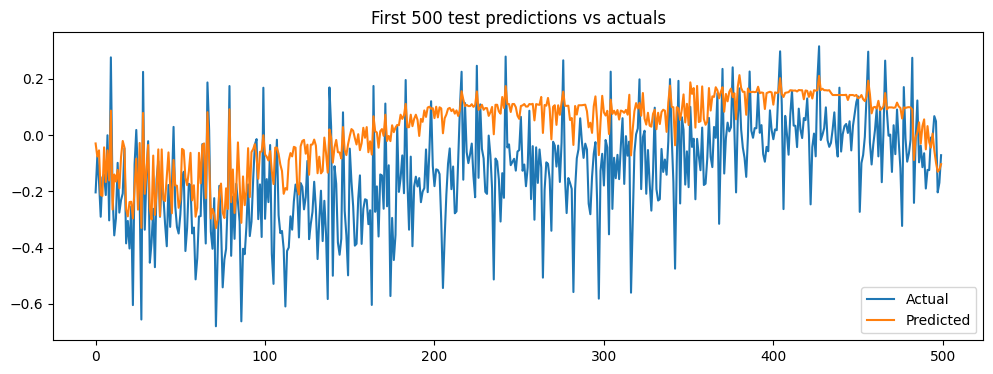

Test error l: 0.6412209941883777
Test error r: 0.030756511442527334
Test error m: 0.9722690890355908

Test Year: 2018 | Training Years: 2016 to 2017
Train samples: 412247 | Test samples: 203208


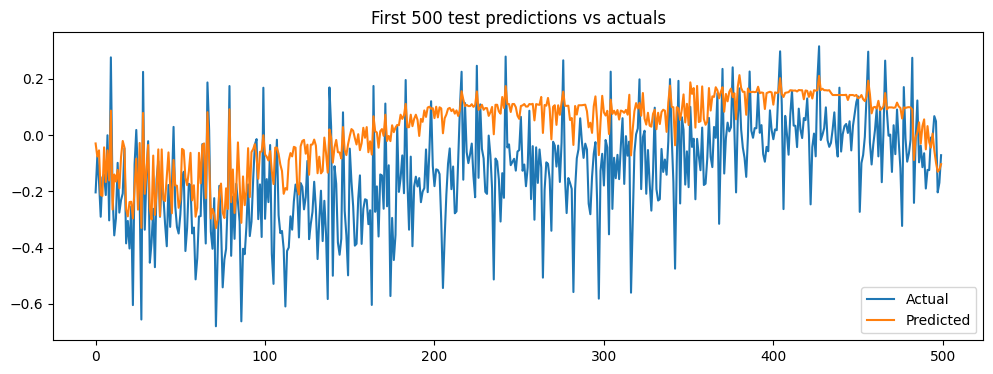

Test error l: 0.5536726970913145
Test error r: -0.9259497274709207
Test error m: 0.9695284805101925

Test Year: 2019 | Training Years: 2017 to 2018
Train samples: 413163 | Test samples: 221172


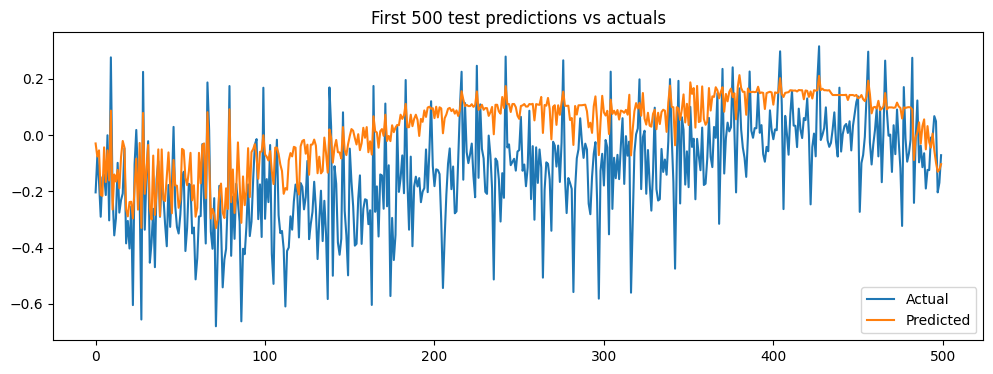

Test error l: 0.6325513342834741
Test error r: 0.06433189813418783
Test error m: 0.967122157201395

Test Year: 2020 | Training Years: 2018 to 2019
Train samples: 424380 | Test samples: 234675


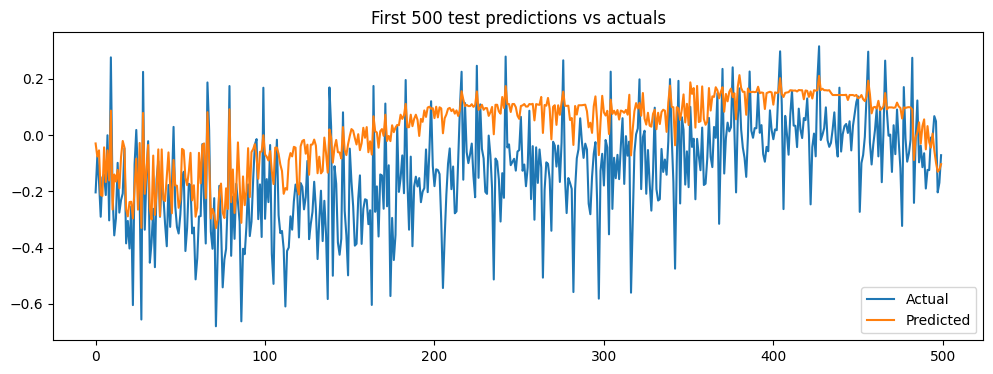

Test error l: 0.6248730585751447
Test error r: 0.07893636347595556
Test error m: 0.9552699414368223

Test Year: 2021 | Training Years: 2019 to 2020
Train samples: 455847 | Test samples: 252009


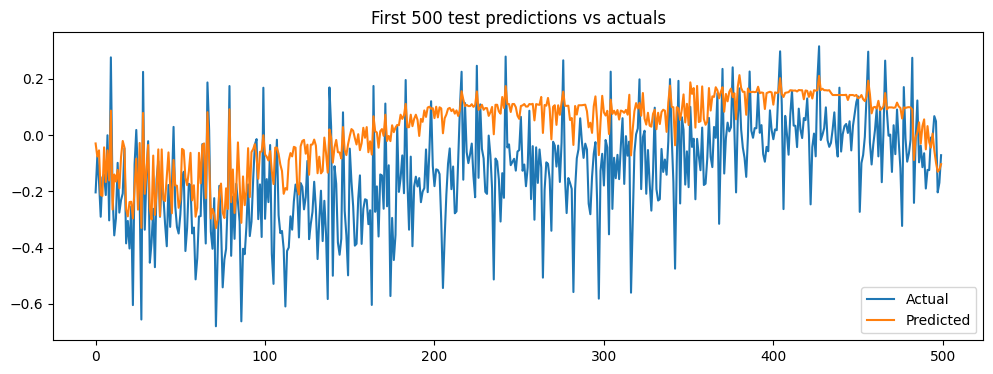

Test error l: 0.5596761410825193
Test error r: -1.1705583269240694
Test error m: 0.9544261418211987

Test Year: 2022 | Training Years: 2020 to 2021
Train samples: 486684 | Test samples: 282857


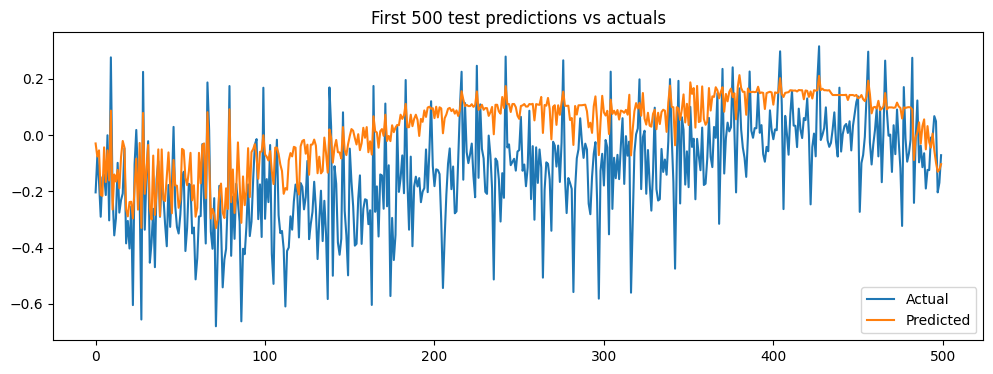

Test error l: 0.45742490040980244
Test error r: 0.02267157472915382
Test error m: 0.9666201236370066

Test Year: 2023 | Training Years: 2021 to 2022
Train samples: 534866 | Test samples: 289771


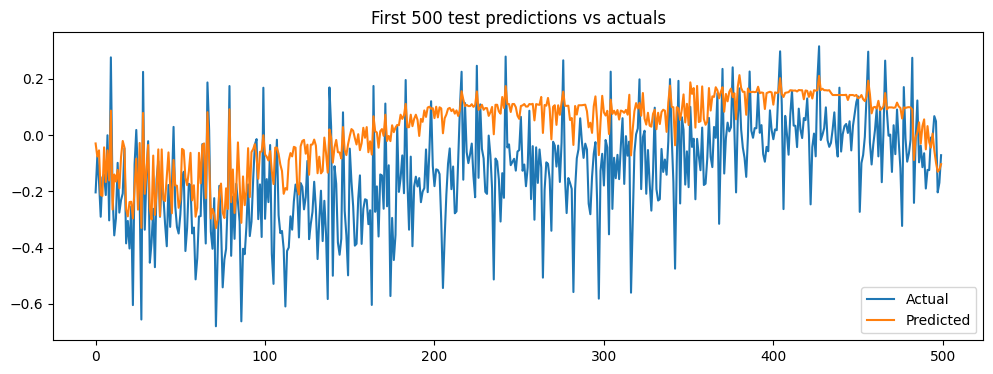

Test error l: 0.5511805806093762
Test error r: 0.05290090057068764
Test error m: 0.9573034503251944

Test Year: 2024 | Training Years: 2022 to 2023
Train samples: 572628 | Test samples: 303966


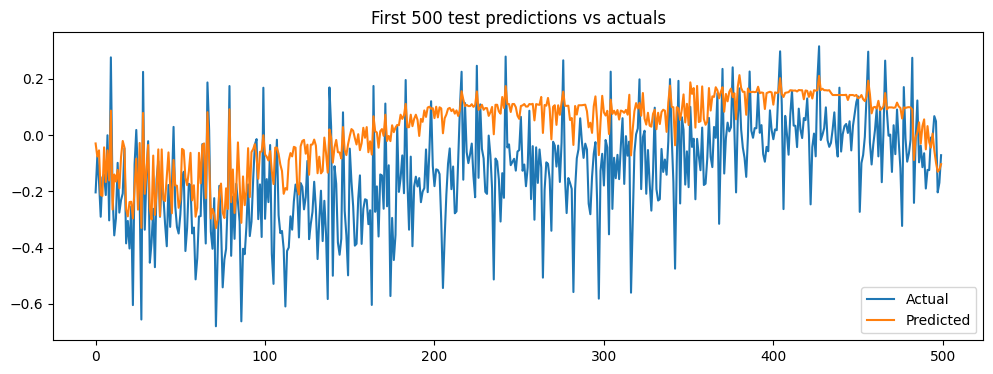

Test error l: 0.5584785650451458
Test error r: 0.09431055505000718
Test error m: 0.9559820999556087
Overall Train Metrics:
MAE: 0.08757956442186923, RMSE: 0.11457747805482608, R²: 0.6598913772421887
Overall Test Metrics:
MAE: 0.09970171290119655, RMSE: 0.1314852379698742, R²: 0.565315262240726
Overall Train Metrics R:
MAE: 0.46143919719326126, RMSE: 0.9238768513668529, R²: 0.38995110594559135
Overall Test Metrics R:
MAE: 0.7555867666963852, RMSE: 1.4635074897626807, R²: 0.09660492023274425
Overall Train Metrics:
MAE: 0.2889479646295097, RMSE: 0.6581514489515926, R²: 0.9676587380397726
Overall Test Metrics:
MAE: 0.29863571657144106, RMSE: 0.6833173884974043, R²: 0.565315262240726
================== DoubleMLPLIV Object ==================

------------------ Data summary      ------------------
Outcome variable: log_consumption
Treatment variable(s): ['log_DayAheadPriceEUR']
Cluster variable(s): ['Country']
Covariates: ['HourOfWeek_165', 'log_Total_Wind_Generation_lag5', 'log_Total_Wind_G

In [19]:
dml_pliv_obj_lags_1, filtered_data_lags_1, importance_df_lags_1, fold_metrics_df_lags_1, importance_all_folds_df_lags_1, fold_coefficients_lags_1 = dml_rolling_window(processed_data_new, 
                                                                                                                             covariates_new, 
                                                                                                                             dependent_variable = 'log_consumption',
                                                                                                                             manual_params_l=manual_params_l,
                                                                                                                             manual_params_r=manual_params_r,
                                                                                                                             manual_params_m=manual_params_m)
          

In [ ]:
# Display 20 maximum values
top_20_log_consumption = processed_data_new['log_consumption'].nlargest(20)
print("Top 20 log_consumption values:")
print(top_20_log_consumption)

# Display 20 minimum values
bottom_20_log_consumption = processed_data_new['log_consumption'].nsmallest(20)
print("\nBottom 20 log_consumption values:")
print(bottom_20_log_consumption)


## CIV(Wt | Pt → Dt | Wt−1,...,Wt−50)

In [11]:
processed_data, covariates = prepare_data_lags_with_iv_lags(
    data_1,
    base_covariates=['Price_gas', 'Price_coal', 'Price_EUA'],
    include_interactions={'block': ['tempbin', 'tempbin2', 'Solar_MWh']},
    dependent_variable = 'consumption_normalized'
)

<ipython-input-7-d39b28252388>:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[lag_col] = (
<ipython-input-7-d39b28252388>:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[lag_col] = (
<ipython-input-7-d39b28252388>:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[lag_col] = (
<ipy

In [12]:
covariates

['HourOfWeek_98',
 'PriceArea_FR',
 'PriceArea_IT_SICI',
 'HourOfWeek_88',
 'HourOfWeek_5',
 'HourOfWeek_34',
 'HourOfWeek_142',
 'Total_Wind_Generation_lag3',
 'HourOfWeek_71',
 'HourOfWeek_37',
 'HourOfWeek_33',
 'HourOfWeek_167',
 'HourOfWeek_46',
 'HourOfWeek_95',
 'HourOfWeek_112',
 'HourOfWeek_20',
 'HourOfWeek_121',
 'HourOfWeek_113',
 'HourOfWeek_152',
 'HourOfWeek_157',
 'HourOfWeek_89',
 'HourOfWeek_105',
 'HourOfWeek_43',
 'PriceArea_IT_CALA',
 'HourOfWeek_99',
 'HourOfWeek_161',
 'PriceArea_PL',
 'PriceArea_LV',
 'Month_5',
 'Total_Wind_Generation_lag49',
 'Month_7',
 'HourOfWeek_165',
 'block_5.0:tempbin',
 'HourOfWeek_153',
 'HourOfWeek_150',
 'Total_Wind_Generation_lag38',
 'block_2.0:tempbin2',
 'HourOfWeek_78',
 'Total_Wind_Generation_lag36',
 'HourOfWeek_156',
 'Total_Wind_Generation_lag28',
 'HourOfWeek_108',
 'block_1.0:tempbin',
 'PriceArea_RO',
 'PriceArea_SE_3',
 'HourOfWeek_14',
 'HourOfWeek_31',
 'Month_9',
 'HourOfWeek_36',
 'PriceArea_CH',
 'Month_4',
 'Total

In [13]:
processed_data = processed_data[processed_data['Time'].dt.year != 2025]

In [19]:
manual_params_l = {
    'learning_rate': 0.02,  # Slightly lower to smooth fit
    'max_depth': 5,         # Shallower trees reduce overfitting
    'n_estimators': 400,    # Faster convergence, lower complexity
    'subsample': 0.8,       # Adds randomness (boost generalization)
    'colsample_bytree': 0.8
}

manual_params_r = {
    'learning_rate': 0.01,
    'max_depth': 3,         # More regularization on treatment model
    'n_estimators': 300,    # Slightly fewer to prevent overfitting noise
    'subsample': 0.7,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,       # L1 regularization
    'reg_lambda': 0.5       # L2 regularization
}

manual_params_m = {
    'learning_rate': 0.01,
    'max_depth': 4,
    'n_estimators': 400,
    'subsample': 0.9,
    'colsample_bytree': 0.9
}



Test Year: 2017 | Training Years: 2015 to 2016
Train samples: 400618 | Test samples: 209955


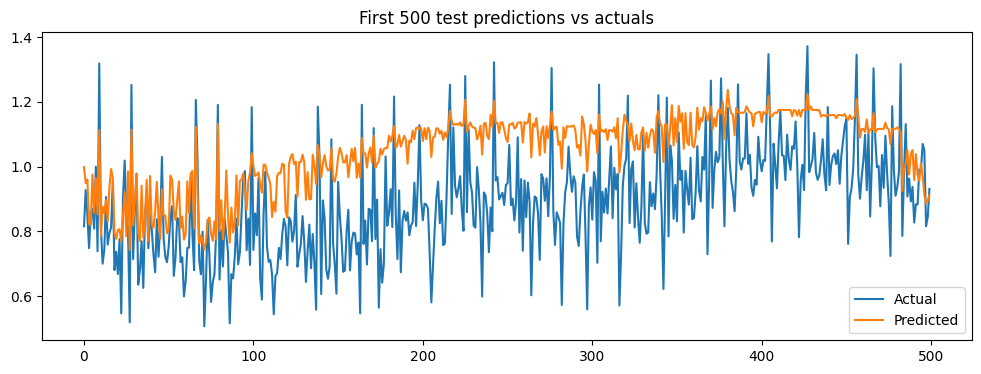

Test error l: 0.637049119668714
Test error r: 0.14989795741773615
Test error m: 0.993864525986336

Test Year: 2018 | Training Years: 2016 to 2017
Train samples: 412247 | Test samples: 203208


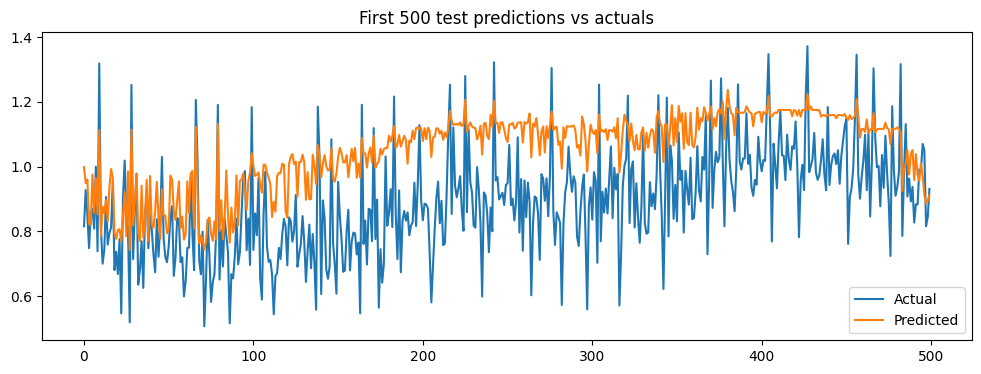

Test error l: 0.5188251791231351
Test error r: 0.0006277083132628647
Test error m: 0.993099109154007

Test Year: 2019 | Training Years: 2017 to 2018
Train samples: 413163 | Test samples: 221172


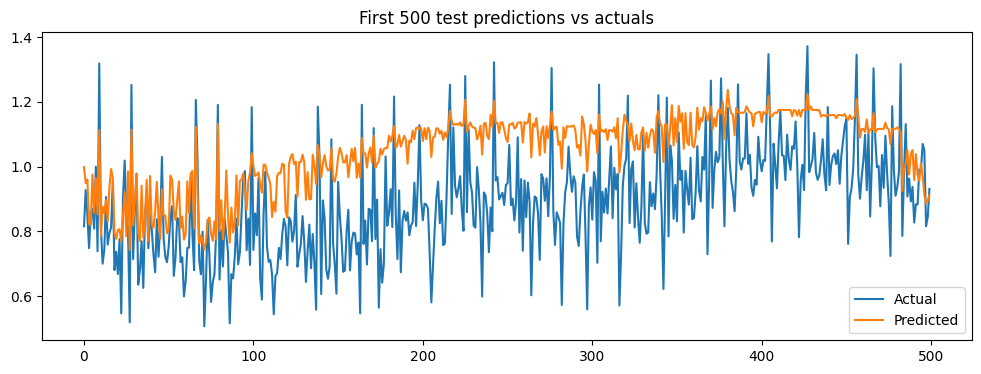

Test error l: 0.6190747711010229
Test error r: 0.18397563427222274
Test error m: 0.9950410322095578

Test Year: 2020 | Training Years: 2018 to 2019
Train samples: 424380 | Test samples: 234675


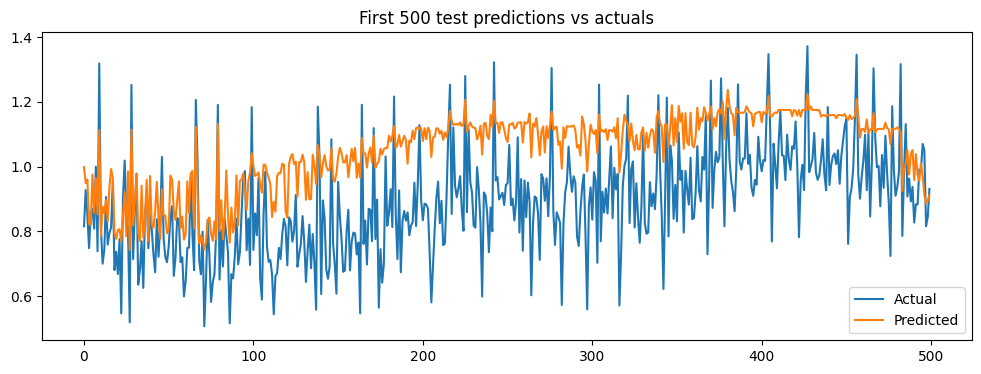

Test error l: 0.6135134312235667
Test error r: 0.0406827161700658
Test error m: 0.9950399983685042

Test Year: 2021 | Training Years: 2019 to 2020
Train samples: 455847 | Test samples: 252009


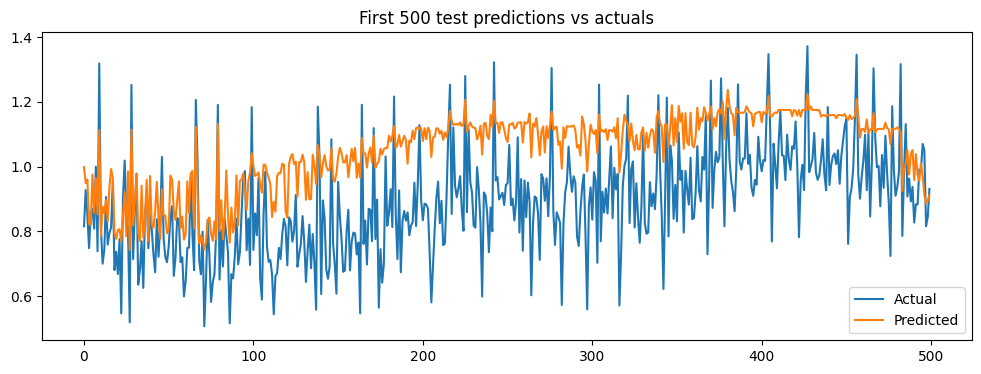

Test error l: 0.5632126935196459
Test error r: -0.6961929885333062
Test error m: 0.9948007174002151

Test Year: 2022 | Training Years: 2020 to 2021
Train samples: 486684 | Test samples: 282857


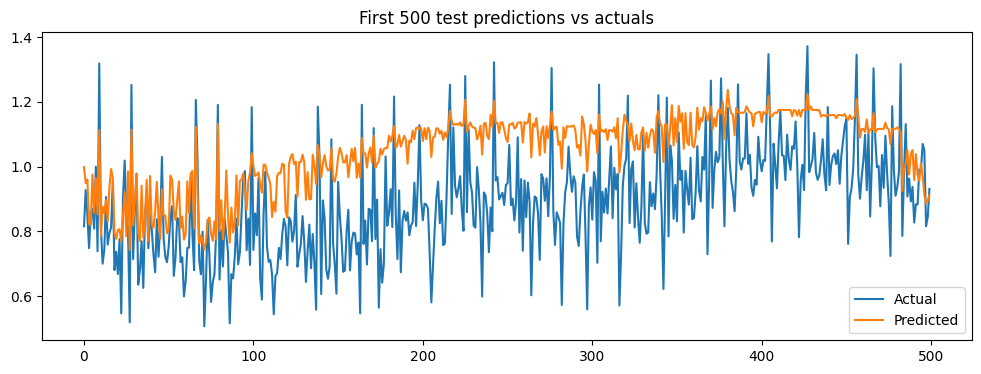

Test error l: 0.46271966853830226
Test error r: 0.35025770725950645
Test error m: 0.9945770597068412

Test Year: 2023 | Training Years: 2021 to 2022
Train samples: 534866 | Test samples: 289771


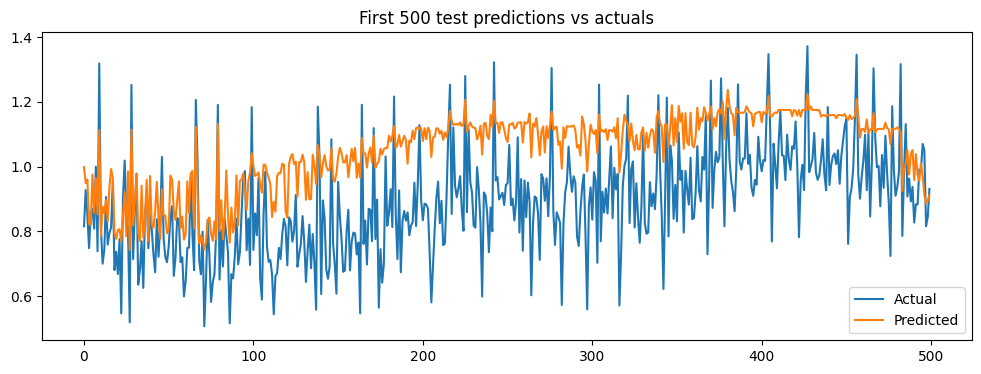

Test error l: 0.5322659834334402
Test error r: 0.17714251220609023
Test error m: 0.9944140092077843

Test Year: 2024 | Training Years: 2022 to 2023
Train samples: 572628 | Test samples: 303966


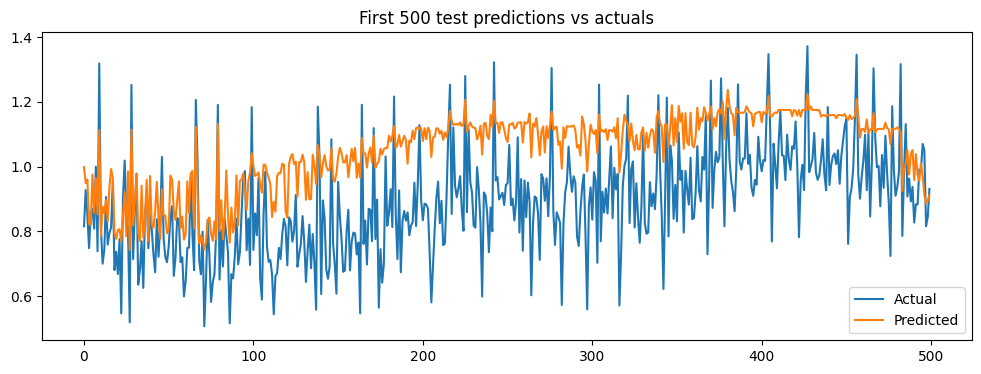

Test error l: 0.5422829052327023
Test error r: 0.13905780598509931
Test error m: 0.993914807737024
Overall Train Metrics:
MAE: 0.08740420746565544, RMSE: 0.11208275564333038, R²: 0.6575961966054914
Overall Test Metrics:
MAE: 0.10062153068203014, RMSE: 0.13008049134102406, R²: 0.5550189242455876
================== DoubleMLPLIV Object ==================

------------------ Data summary      ------------------
Outcome variable: consumption_normalized
Treatment variable(s): ['DayAheadPriceEUR']
Cluster variable(s): ['Country']
Covariates: ['Total_Wind_Generation_lag26', 'HourOfWeek_38', 'block_2.0:Solar_MWh', 'PriceArea_LT', 'Total_Wind_Generation_lag4', 'Total_Wind_Generation_lag25', 'HourOfWeek_20', 'HourOfWeek_114', 'HourOfWeek_125', 'Total_Wind_Generation_lag38', 'PriceArea_BG', 'block_2.0:tempbin', 'HourOfWeek_54', 'Total_Wind_Generation_lag46', 'HourOfWeek_6', 'Price_gas', 'HourOfWeek_87', 'HourOfWeek_15', 'HourOfWeek_163', 'Total_Wind_Generation_lag3', 'PriceArea_FI', 'Month_4', 'Ho

In [46]:
dml_pliv_obj_lags_1, filtered_data_lags_1, importance_df_lags_1, fold_metrics_df_lags_1, importance_all_folds_df_lags_1, fold_coefficients_lags_1 = dml_rolling_window(processed_data, 
                                                                                                                             covariates, 
                                                                                                                             dependent_variable = 'consumption_normalized',
                                                                                                                             manual_params_l=manual_params_l,
                                                                                                                             manual_params_r=manual_params_r,
                                                                                                                             manual_params_m=manual_params_m)
          


Test Year: 2017 | Training Years: 2015 to 2016
Train samples: 400618 | Test samples: 209955


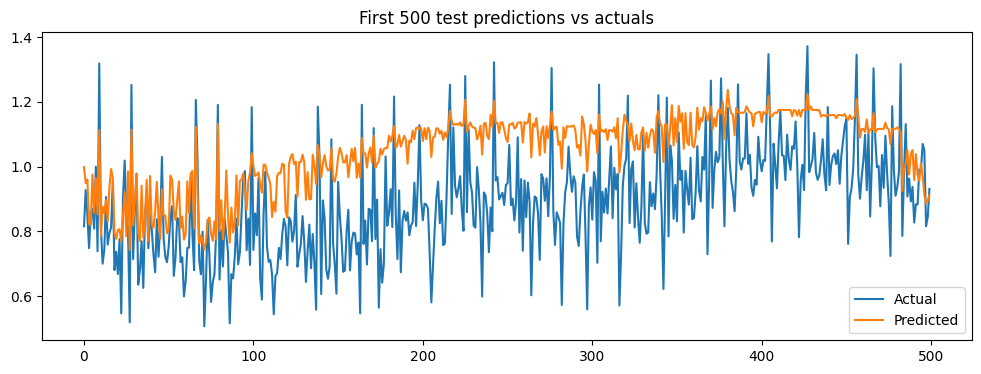

Test error l: 0.637049119668714
Test error r: 0.14989795741773615
Test error m: 0.993864525986336

Test Year: 2018 | Training Years: 2016 to 2017
Train samples: 412247 | Test samples: 203208


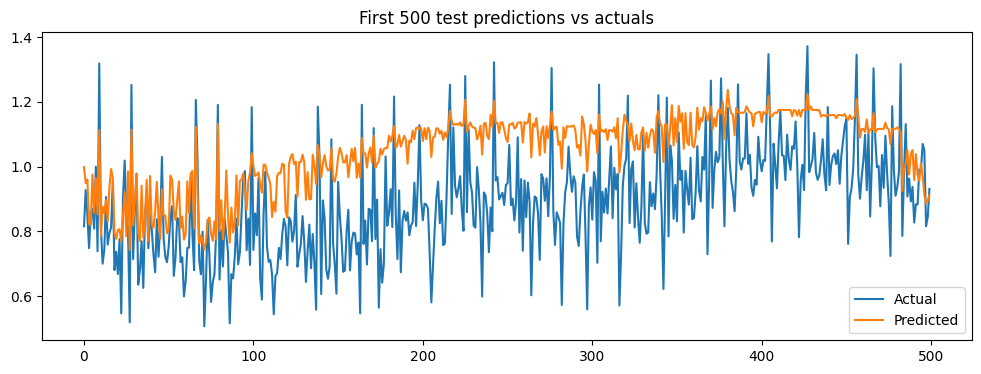

Test error l: 0.5188251791231351
Test error r: 0.0006277083132628647
Test error m: 0.993099109154007

Test Year: 2019 | Training Years: 2017 to 2018
Train samples: 413163 | Test samples: 221172


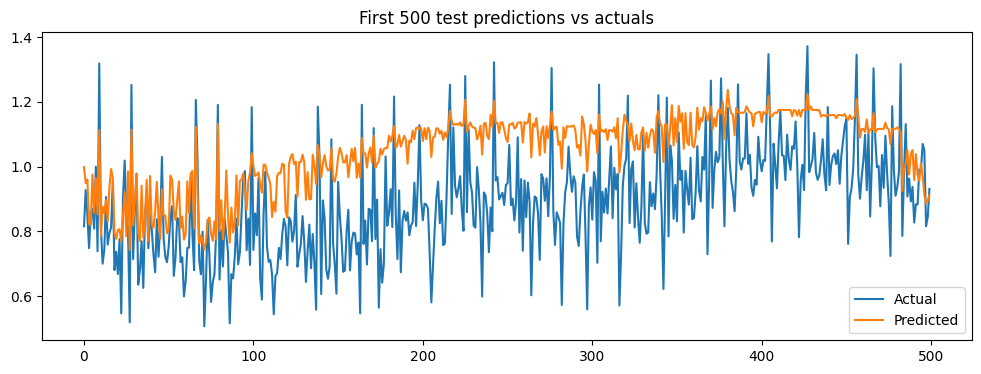

Test error l: 0.6190747711010229
Test error r: 0.18397563427222274
Test error m: 0.9950410322095578

Test Year: 2020 | Training Years: 2018 to 2019
Train samples: 424380 | Test samples: 234675


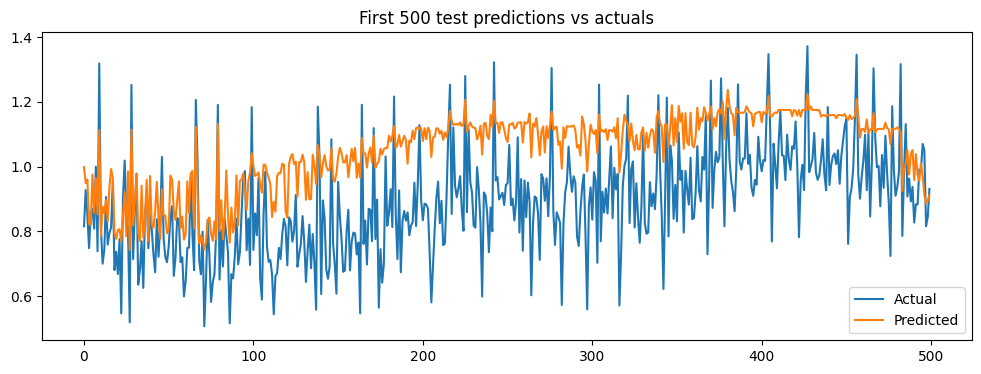

Test error l: 0.6135134312235667
Test error r: 0.0406827161700658
Test error m: 0.9950399983685042

Test Year: 2021 | Training Years: 2019 to 2020
Train samples: 455847 | Test samples: 252009


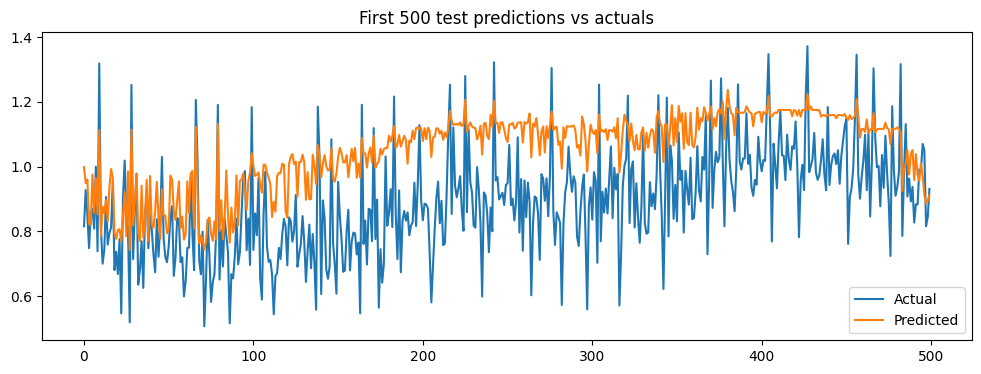

Test error l: 0.5632126935196459
Test error r: -0.6961929885333062
Test error m: 0.9948007174002151

Test Year: 2022 | Training Years: 2020 to 2021
Train samples: 486684 | Test samples: 282857


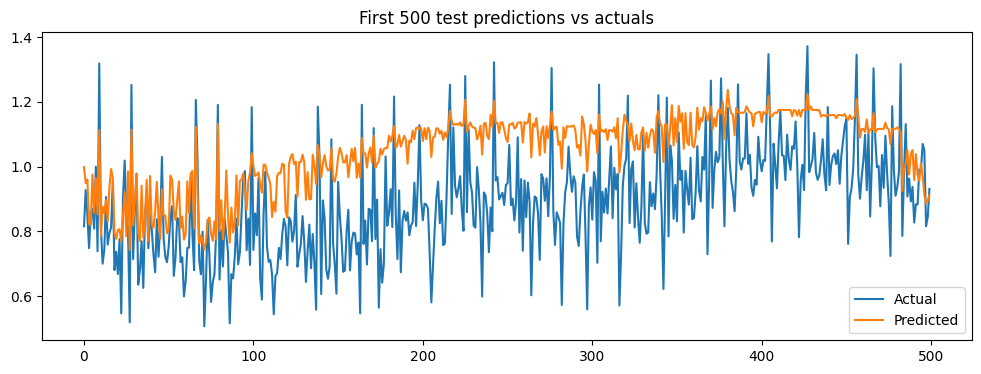

Test error l: 0.46271966853830226
Test error r: 0.35025770725950645
Test error m: 0.9945770597068412

Test Year: 2023 | Training Years: 2021 to 2022
Train samples: 534866 | Test samples: 289771


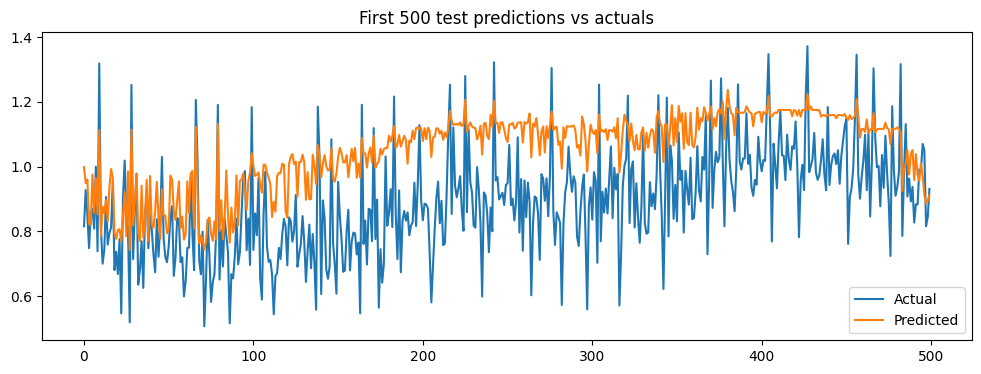

Test error l: 0.5322659834334402
Test error r: 0.17714251220609023
Test error m: 0.9944140092077843

Test Year: 2024 | Training Years: 2022 to 2023
Train samples: 572628 | Test samples: 303966


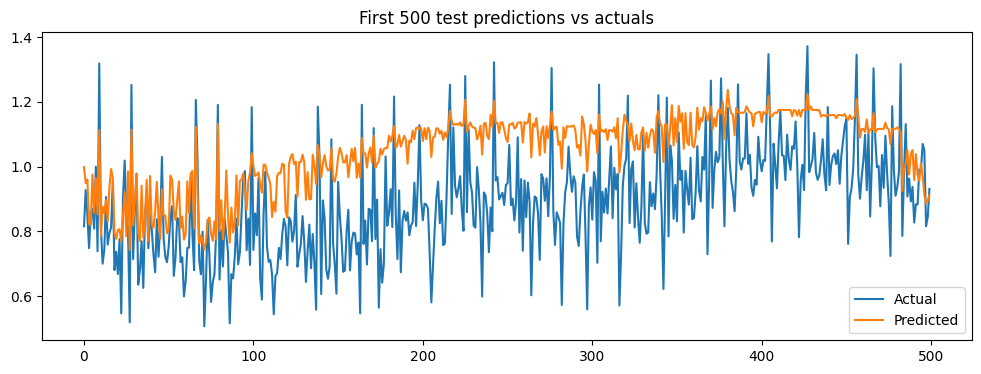

Test error l: 0.5422829052327023
Test error r: 0.13905780598509931
Test error m: 0.993914807737024
Overall Train Metrics:
MAE: 0.08740420746565544, RMSE: 0.11208275564333038, R²: 0.6575961966054914
Overall Test Metrics:
MAE: 0.10062153068203014, RMSE: 0.13008049134102406, R²: 0.5550189242455876
================== DoubleMLPLIV Object ==================

------------------ Data summary      ------------------
Outcome variable: consumption_normalized
Treatment variable(s): ['DayAheadPriceEUR']
Cluster variable(s): ['Country']
Covariates: ['Total_Wind_Generation_lag26', 'HourOfWeek_38', 'block_2.0:Solar_MWh', 'PriceArea_LT', 'Total_Wind_Generation_lag4', 'Total_Wind_Generation_lag25', 'HourOfWeek_20', 'HourOfWeek_114', 'HourOfWeek_125', 'Total_Wind_Generation_lag38', 'PriceArea_BG', 'block_2.0:tempbin', 'HourOfWeek_54', 'Total_Wind_Generation_lag46', 'HourOfWeek_6', 'Price_gas', 'HourOfWeek_87', 'HourOfWeek_15', 'HourOfWeek_163', 'Total_Wind_Generation_lag3', 'PriceArea_FI', 'Month_4', 'Ho

In [65]:
dml_pliv_obj_lags_1, filtered_data_lags_1, importance_df_lags_1, fold_metrics_df_lags_1, importance_all_folds_df_lags_1, fold_coefficients_lags_1 = dml_rolling_window(processed_data, 
                                                                                                                             covariates, 
                                                                                                                             dependent_variable = 'consumption_normalized',
                                                                                                                             manual_params_l=manual_params_l,
                                                                                                                             manual_params_r=manual_params_r,
                                                                                                                             manual_params_m=manual_params_m)
          

In [66]:
filtered_data_lags_1.to_csv("second_model_lags.csv", index=False)
importance_df_lags_1.to_csv("second_model_lags_importance_df.csv", index=False)
fold_coefficients_lags_1 = pd.DataFrame(fold_coefficients_lags_1)
fold_coefficients_lags_1.to_csv("second_model_lags_fold_coefficients.csv", index=False)

In [20]:
covariates_regression = [var for var in covariates if var not in ['HourOfWeek_0', 'Month_1']]

In [21]:
outcome_var = 'consumption_normalized'
treatment_var = ['DayAheadPriceEUR']
instrument_vars = ['Total_Wind_Generation']
cluster_var = 'Country'

# Prepare matrices
Y = filtered_data_lags[outcome_var]
D = filtered_data_lags[treatment_var]
Z = filtered_data_lags[instrument_vars]
W = filtered_data_lags[covariates_regression]

# Fit the IV model
iv_model_check_filter = IV2SLS(dependent=Y, exog=W, endog=D, instruments=Z).fit(cov_type='clustered', clusters=filtered_data_lags[cluster_var])

# Summary of results
print(iv_model_check_filter.summary)

                            IV-2SLS Estimation Summary                            
Dep. Variable:     consumption_normalized   R-squared:                      0.5687
Estimator:                        IV-2SLS   Adj. R-squared:                 0.5686
No. Observations:                 1997613   F-statistic:                 2.041e+15
Date:                    Sun, Apr 06 2025   P-value (F-stat)                0.0000
Time:                            18:31:54   Distribution:                chi2(288)
Cov. Estimator:                 clustered                                         
                                                                                  
                                      Parameter Estimates                                      
                             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------------------
Total_Wind_Generation_lag26 -4.801e-07  5.613e-0

Test - consumption_normalized Metrics:
  MAE: 0.0856
  RMSE: 0.1168
  R²: 0.6413
consumption_normalized Range: Min = 0.0, Max = 2.7072245076569836, Range = 2.7072245076569836
MAE as percentage of range: 3.16%
RMSE as percentage of range: 4.31%


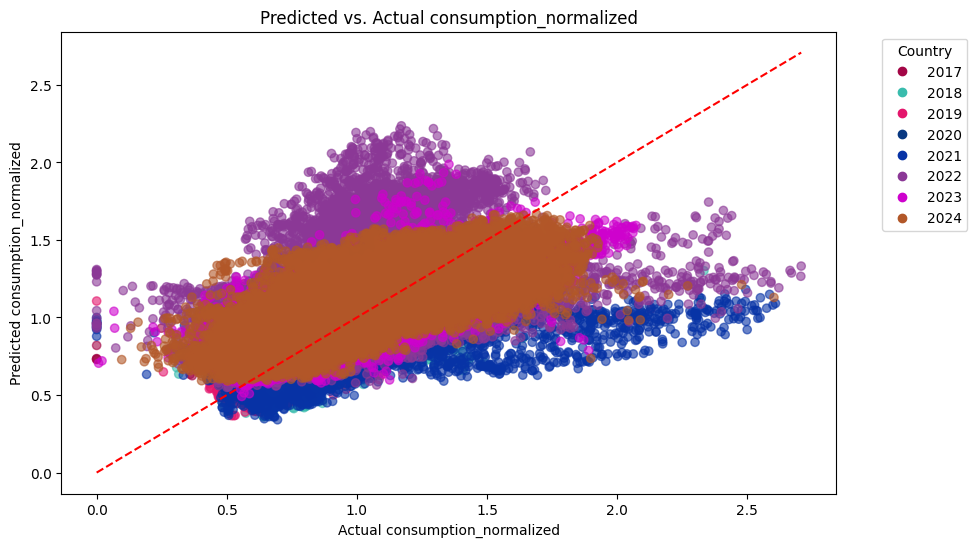

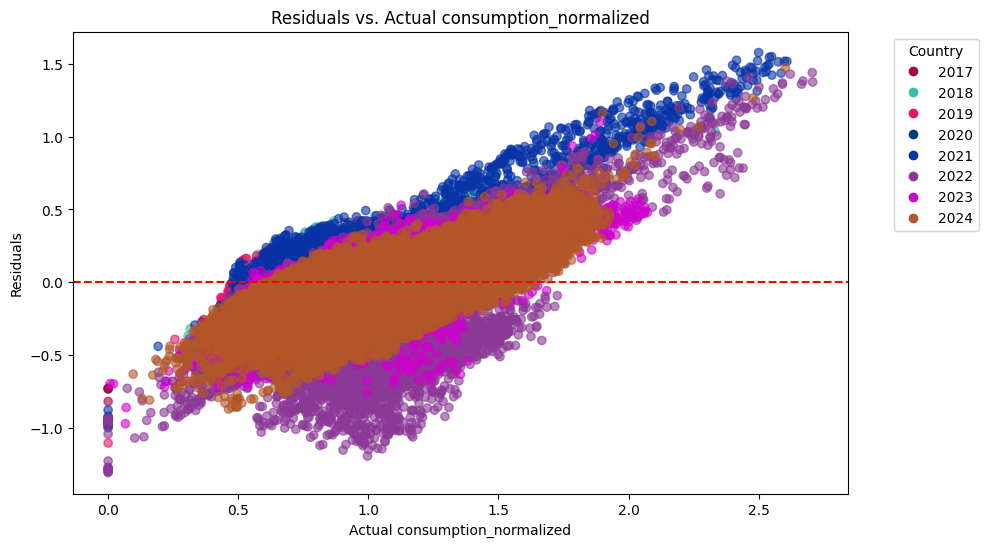

In [22]:
result = evaluate_predictions_country(
    predictions=dml_pliv_obj_lags.predictions['ml_l'].ravel(),
    true_values=filtered_data_lags['consumption_normalized'],
    target_name="consumption_normalized",
    country_values=filtered_data_lags['Year']  # Use the Country column
)

Test - consumption_normalized Metrics:
  MAE: 0.0856
  RMSE: 0.1168
  R²: 0.6413
consumption_normalized Range: Min = 0.0, Max = 2.7072245076569836, Range = 2.7072245076569836
MAE as percentage of range: 3.16%
RMSE as percentage of range: 4.31%


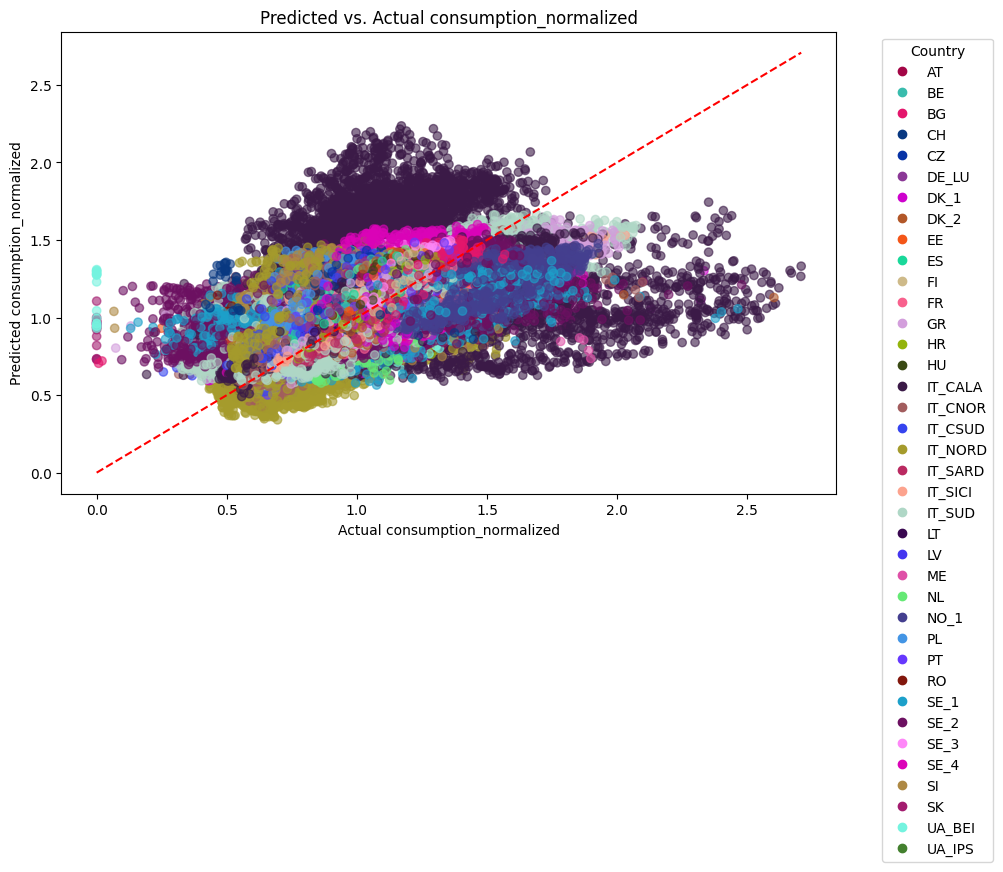

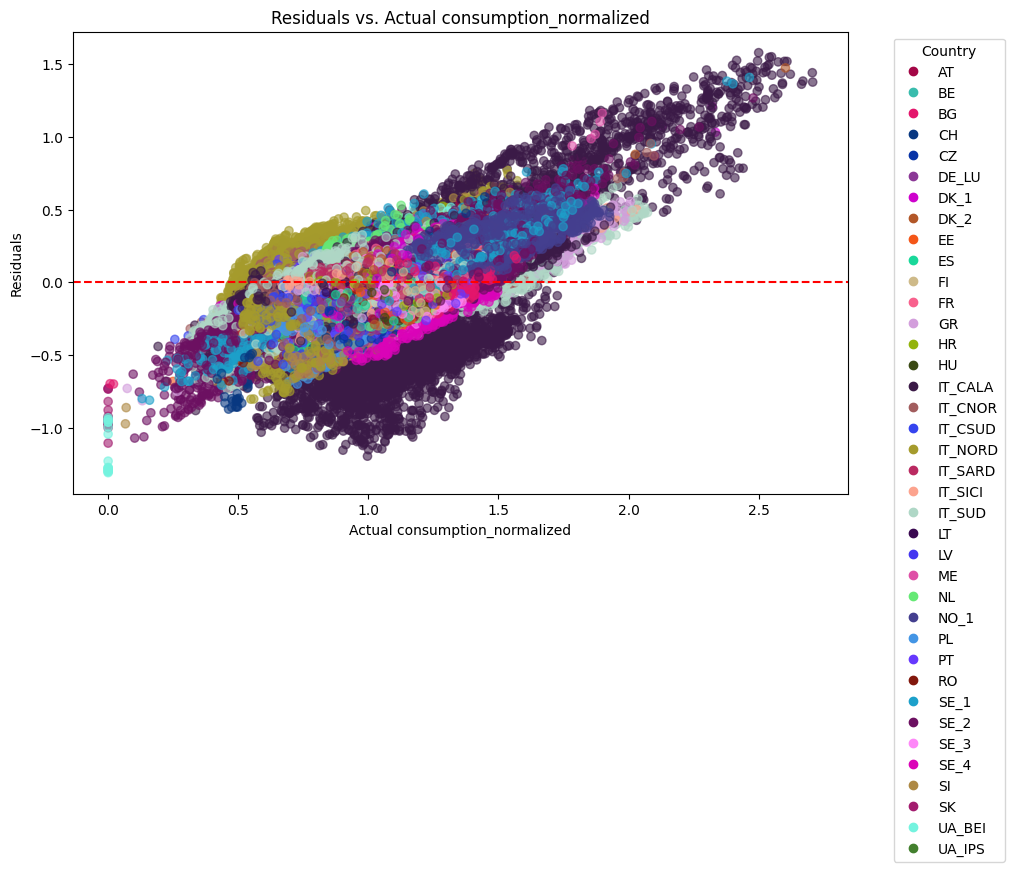

In [24]:
result = evaluate_predictions_country(
    predictions=dml_pliv_obj_lags.predictions['ml_l'].ravel(),
    true_values=filtered_data_lags['consumption_normalized'],
    target_name="consumption_normalized",
    country_values=filtered_data_lags['Country']  # Use the Country column
)

In [39]:
most_important_features = importance_df_lags.sort_values(by='Mean Importance', ascending=False)
most_important_features.head(90)

Feature  Mean Importance  Std Importance
228      HourOfWeek_149         0.038037        0.006185
34   block_1.0:tempbin2         0.028703        0.003185
202      HourOfWeek_150         0.028141        0.003665
8        HourOfWeek_125         0.024627        0.002637
70   block_6.0:tempbin2         0.019616        0.001600
..                  ...              ...             ...
191       HourOfWeek_88         0.003132        0.000971
6         HourOfWeek_20         0.003094        0.000537
274      HourOfWeek_145         0.002968        0.000458
182       HourOfWeek_57         0.002928        0.000804
76        HourOfWeek_44         0.002802        0.000292

[90 rows x 3 columns]

In [43]:
most_important_features.head(70)

Feature  Mean Importance  Std Importance
228      HourOfWeek_149         0.038037        0.006185
34   block_1.0:tempbin2         0.028703        0.003185
202      HourOfWeek_150         0.028141        0.003665
8        HourOfWeek_125         0.024627        0.002637
70   block_6.0:tempbin2         0.019616        0.001600
..                  ...              ...             ...
116      HourOfWeek_143         0.004435        0.000848
260      HourOfWeek_167         0.004430        0.000461
149       HourOfWeek_29         0.004140        0.000945
171        HourOfWeek_7         0.004072        0.000985
281       HourOfWeek_70         0.003853        0.000462

[70 rows x 3 columns]

## Importance

In [3]:
importance_df_lags = pd.read_csv("second_model_lags_importance_df.csv")

In [23]:
important_features = importance_df_lags[importance_df_lags['Mean Importance'] > 0.001]['Feature']
important_features

0                block_1.0:tempbin
1               block_6.0:tempbin2
2               block_1.0:tempbin2
3                block_6.0:tempbin
4                          Month_1
                  ...             
109                   PriceArea_BG
110                PriceArea_DE_LU
111                   HourOfWeek_1
112              PriceArea_IT_SARD
113    Total_Wind_Generation_lag16
Name: Feature, Length: 114, dtype: object

In [22]:
important_features = importance_df_lags[importance_df_lags['Mean Importance'] > 0.0004]['Feature'].tolist()
important_features

['block_1.0:tempbin',
 'block_6.0:tempbin2',
 'block_1.0:tempbin2',
 'block_6.0:tempbin',
 'Month_1',
 'Month_2',
 'HourOfWeek_149',
 'Month_5',
 'HourOfWeek_150',
 'HourOfWeek_125',
 'HourOfWeek_151',
 'Month_12',
 'HourOfWeek_157',
 'HourOfWeek_158',
 'HourOfWeek_156',
 'HourOfWeek_159',
 'HourOfWeek_126',
 'HourOfWeek_153',
 'HourOfWeek_155',
 'HourOfWeek_154',
 'HourOfWeek_164',
 'Month_3',
 'HourOfWeek_140',
 'HourOfWeek_152',
 'block_3.0:tempbin',
 'HourOfWeek_56',
 'HourOfWeek_69',
 'HourOfWeek_132',
 'HourOfWeek_80',
 'HourOfWeek_134',
 'Price_gas',
 'HourOfWeek_32',
 'HourOfWeek_45',
 'HourOfWeek_160',
 'HourOfWeek_133',
 'Month_4',
 'HourOfWeek_21',
 'HourOfWeek_93',
 'HourOfWeek_104',
 'block_5.0:tempbin',
 'HourOfWeek_131',
 'HourOfWeek_135',
 'HourOfWeek_55',
 'Price_coal',
 'HourOfWeek_163',
 'HourOfWeek_79',
 'HourOfWeek_31',
 'HourOfWeek_130',
 'HourOfWeek_0',
 'Price_EUA',
 'HourOfWeek_144',
 'HourOfWeek_65',
 'HourOfWeek_89',
 'HourOfWeek_167',
 'HourOfWeek_41',
 'Hou


Test Year: 2017 | Training Years: 2015 to 2016
Train samples: 400618 | Test samples: 209955


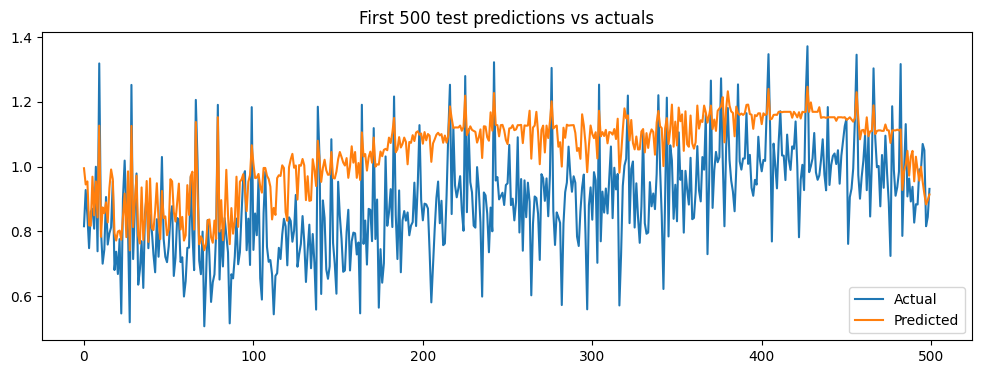

Test error l: 0.639185744060234
Test error r: 0.15556575593030375
Test error m: 0.9383282043696095

Test Year: 2018 | Training Years: 2016 to 2017
Train samples: 412247 | Test samples: 203208


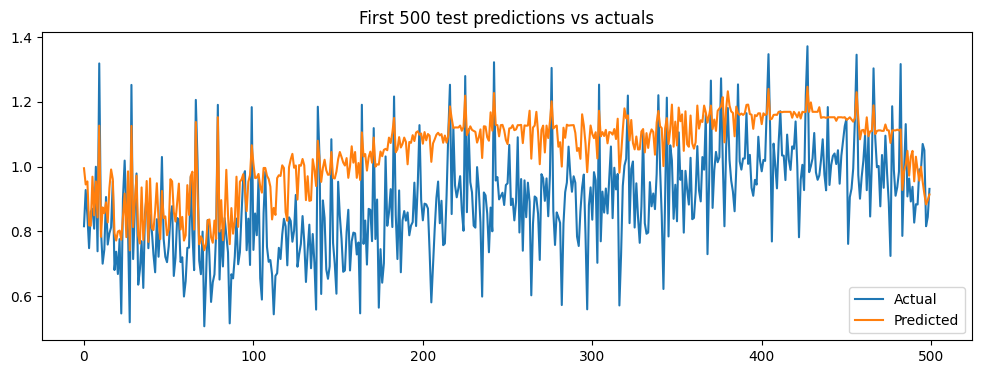

Test error l: 0.5012680831478631
Test error r: -0.008935777130654854
Test error m: 0.9341552947235756

Test Year: 2019 | Training Years: 2017 to 2018
Train samples: 413163 | Test samples: 221172


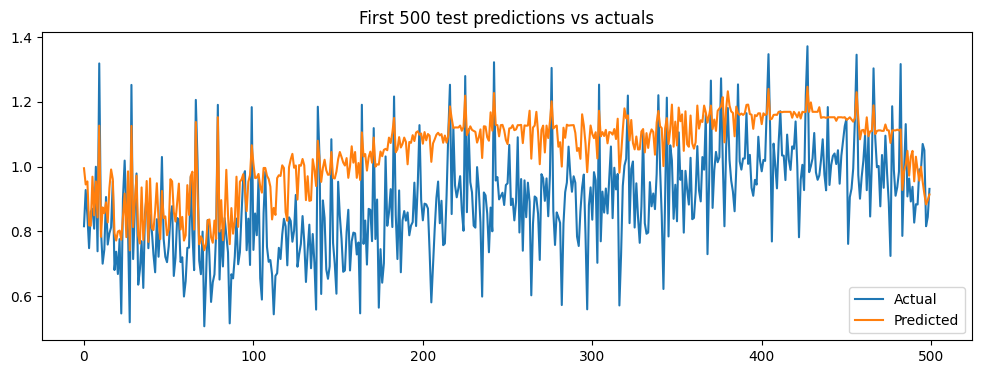

Test error l: 0.6310613732622734
Test error r: 0.17966047029050547
Test error m: 0.938860822081923

Test Year: 2020 | Training Years: 2018 to 2019
Train samples: 424380 | Test samples: 234675


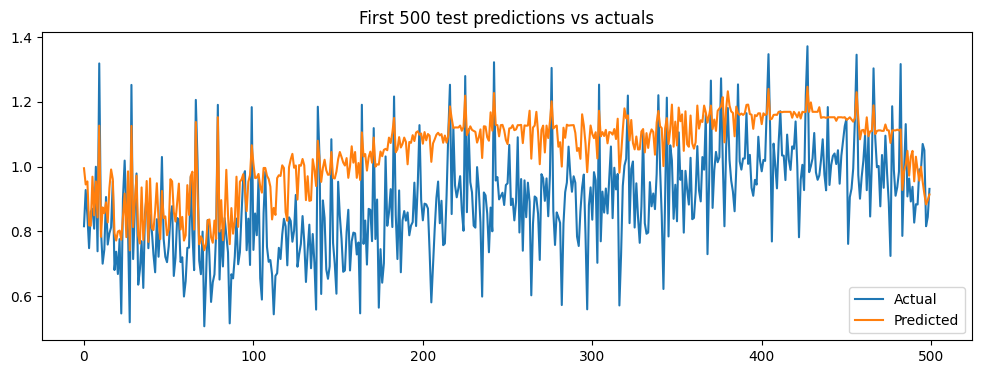

Test error l: 0.6148107687456598
Test error r: 0.03321041422254045
Test error m: 0.9380888664605121

Test Year: 2021 | Training Years: 2019 to 2020
Train samples: 455847 | Test samples: 252009


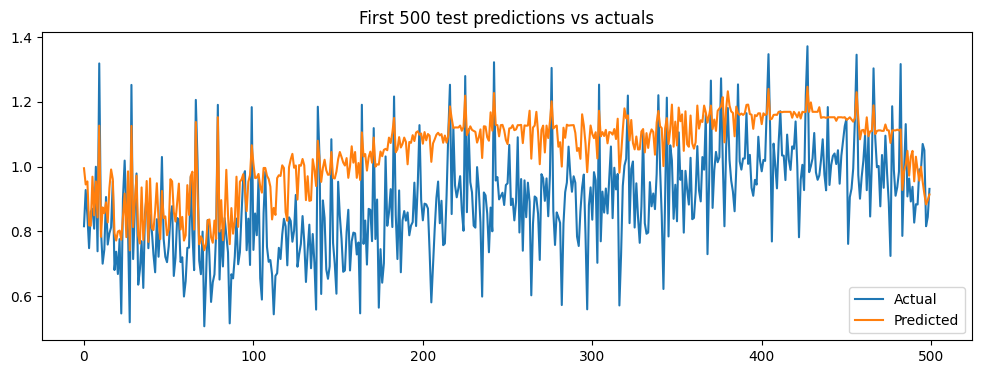

Test error l: 0.557618362107523
Test error r: -0.664929834146968
Test error m: 0.9383914413061423

Test Year: 2022 | Training Years: 2020 to 2021
Train samples: 486684 | Test samples: 282857


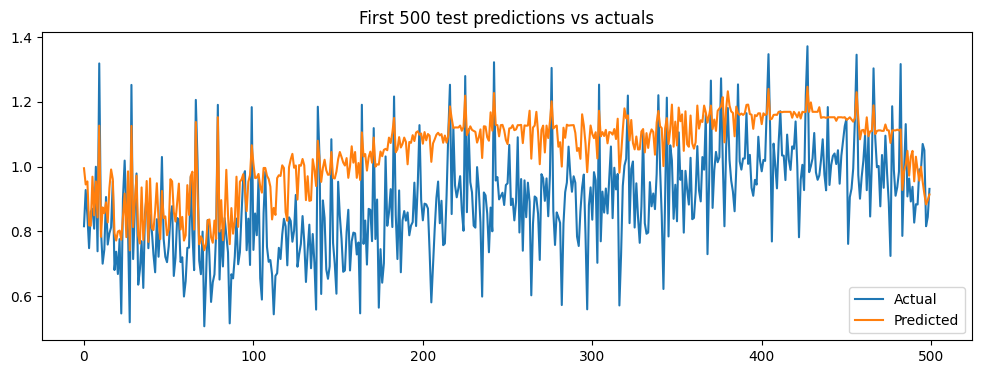

Test error l: 0.4536033318701743
Test error r: 0.3376747276159858
Test error m: 0.935826164570854

Test Year: 2023 | Training Years: 2021 to 2022
Train samples: 534866 | Test samples: 289771


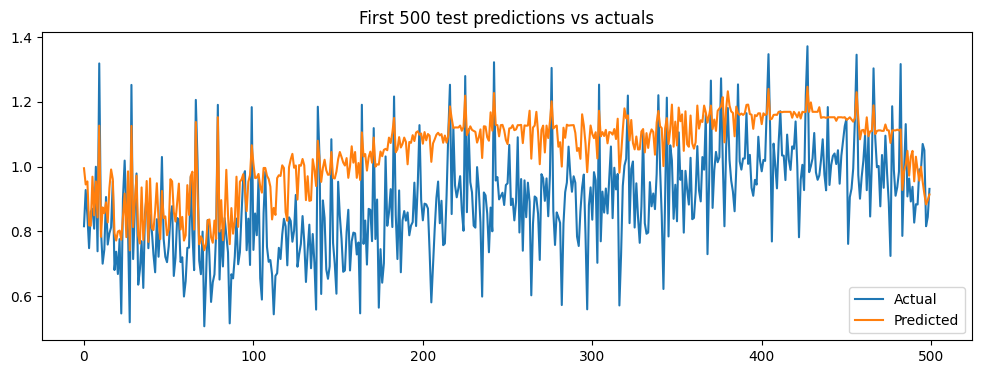

Test error l: 0.5322787201088517
Test error r: 0.15706386386204196
Test error m: 0.9381685672965049

Test Year: 2024 | Training Years: 2022 to 2023
Train samples: 572628 | Test samples: 303966


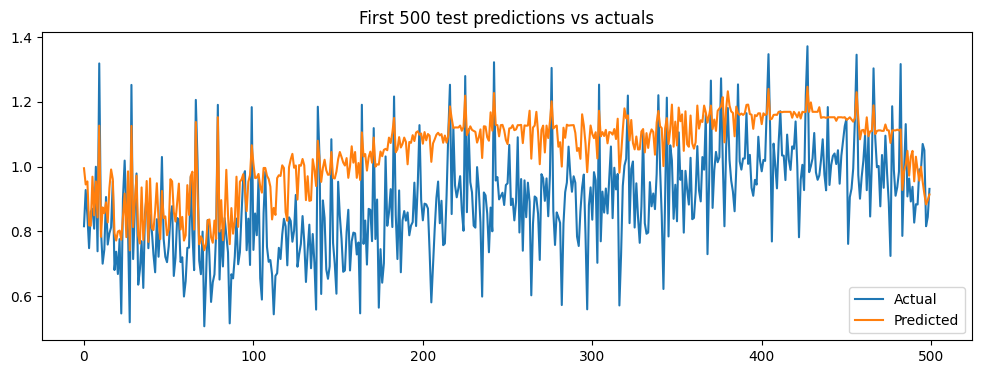

Test error l: 0.5726241018999951
Test error r: 0.12657117751692892
Test error m: 0.9316081632479674
Overall Train Metrics:
MAE: 0.08742259122124188, RMSE: 0.1120928520917678, R²: 0.6575345061512816
Overall Test Metrics:
MAE: 0.10025662146765735, RMSE: 0.12962850575109575, R²: 0.5581058685109672
================== DoubleMLPLIV Object ==================

------------------ Data summary      ------------------
Outcome variable: consumption_normalized
Treatment variable(s): ['DayAheadPriceEUR']
Cluster variable(s): ['Country']
Covariates: ['block_1.0:tempbin', 'block_6.0:tempbin2', 'block_1.0:tempbin2', 'block_6.0:tempbin', 'Month_1', 'Month_2', 'HourOfWeek_149', 'Month_5', 'HourOfWeek_150', 'HourOfWeek_125', 'HourOfWeek_151', 'Month_12', 'HourOfWeek_157', 'HourOfWeek_158', 'HourOfWeek_156', 'HourOfWeek_159', 'HourOfWeek_126', 'HourOfWeek_153', 'HourOfWeek_155', 'HourOfWeek_154', 'HourOfWeek_164', 'Month_3', 'HourOfWeek_140', 'HourOfWeek_152', 'block_3.0:tempbin', 'HourOfWeek_56', 'HourOfW

In [23]:
dml_pliv_obj_lags_imp, filtered_data_lags_imp, importance_df_lags_imp, fold_metrics_df_lags_imp, importance_all_folds_df_lags_imp, fold_coefficients_lags_imp = dml_rolling_window(processed_data, 
                                                                                                                             important_features, 
                                                                                                                             dependent_variable = 'consumption_normalized',
                                                                                                                             manual_params_l=manual_params_l,
                                                                                                                             manual_params_r=manual_params_r,
                                                                                                                             manual_params_m=manual_params_m)
          

In [24]:
filtered_data_lags_imp.to_csv("second_model_lags_importance.csv", index=False)
importance_df_lags_imp.to_csv("second_model_lags_importance_df_importance.csv", index=False)
fold_coefficients_lags_imp = pd.DataFrame(fold_coefficients_lags_imp)
fold_coefficients_lags_imp.to_csv("second_model_lags_fold_coefficients_lags_imp_1.csv", index=False)

In [61]:
param_dist_xgb = {
    'n_estimators': [500, 700, 1000],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.03]
}


Test Year: 2017 | Training Years: 2015 to 2016
Train samples: 400618 | Test samples: 209955
Best L Parameters: {'learning_rate': 0.03, 'max_depth': 10, 'n_estimators': 1000}
Best R Parameters: {'learning_rate': 0.03, 'max_depth': 8, 'n_estimators': 1000}
Best M Parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 500}


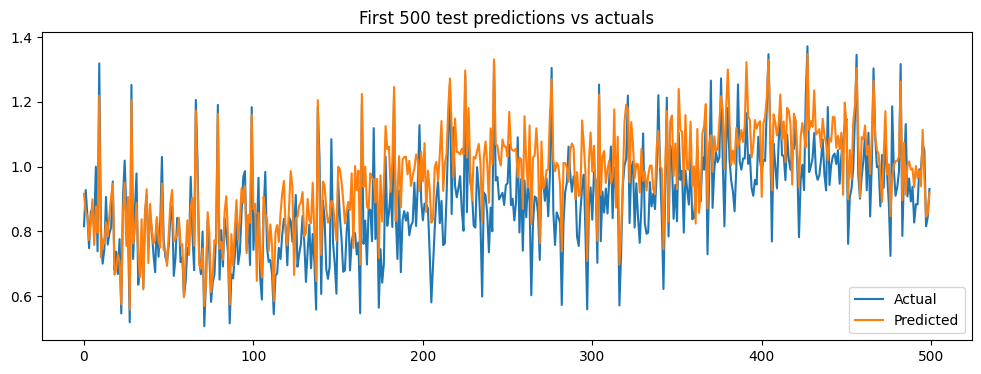

Test error l: 0.7733883820533272
Test error r: 0.31767090227051564
Test error m: 0.6279061830789918

Test Year: 2018 | Training Years: 2016 to 2017
Train samples: 412247 | Test samples: 203208


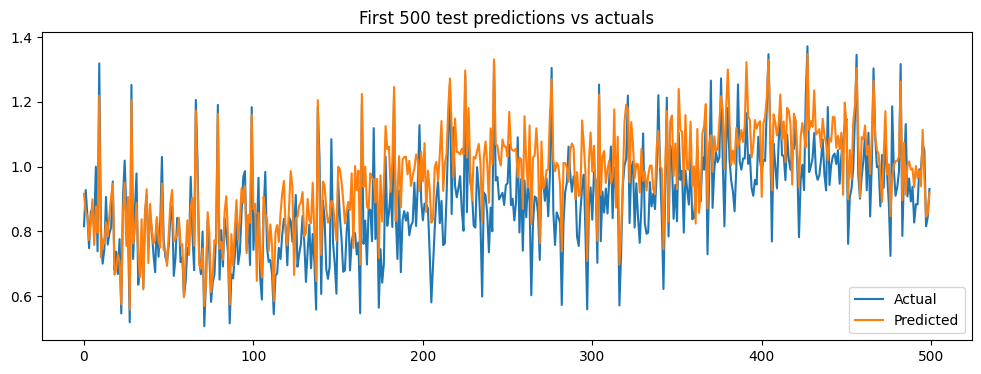

Test error l: 0.5620354485268051
Test error r: -0.5963134435847386
Test error m: 0.6057636526167709

Test Year: 2019 | Training Years: 2017 to 2018
Train samples: 413163 | Test samples: 221172


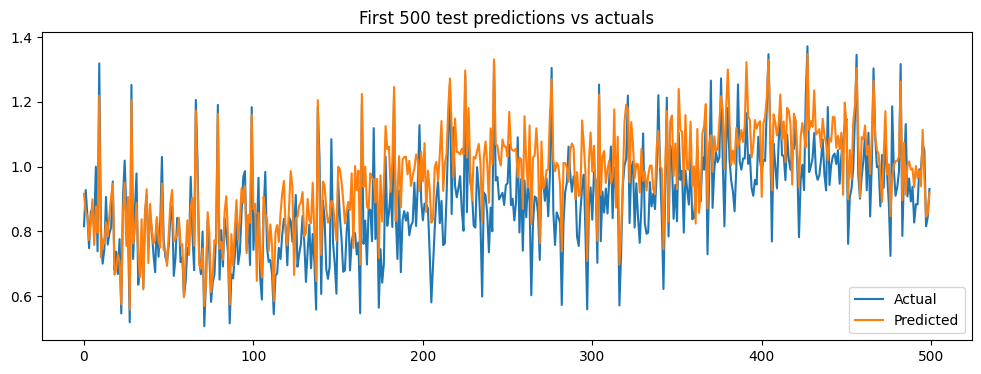

Test error l: 0.6166937238345845
Test error r: 0.3374029497286253
Test error m: 0.5899712067434952

Test Year: 2020 | Training Years: 2018 to 2019
Train samples: 424380 | Test samples: 234675


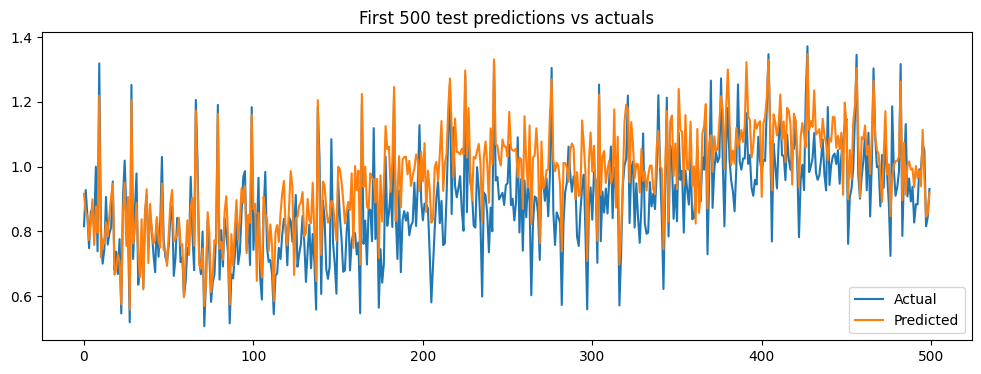

Test error l: 0.7630073207650017
Test error r: 0.08209819919065064
Test error m: 0.6279700554198943

Test Year: 2021 | Training Years: 2019 to 2020
Train samples: 455847 | Test samples: 252009


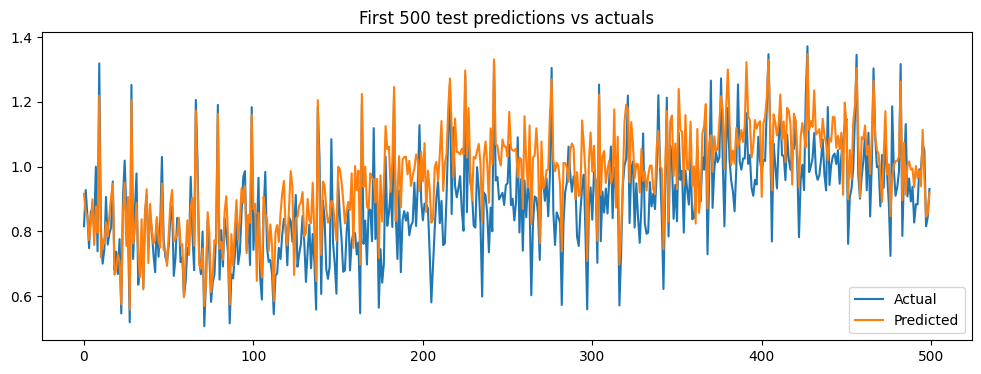

Test error l: 0.4800933928705752
Test error r: -0.8905695736430472
Test error m: 0.27526668613725236

Test Year: 2022 | Training Years: 2020 to 2021
Train samples: 486684 | Test samples: 282857


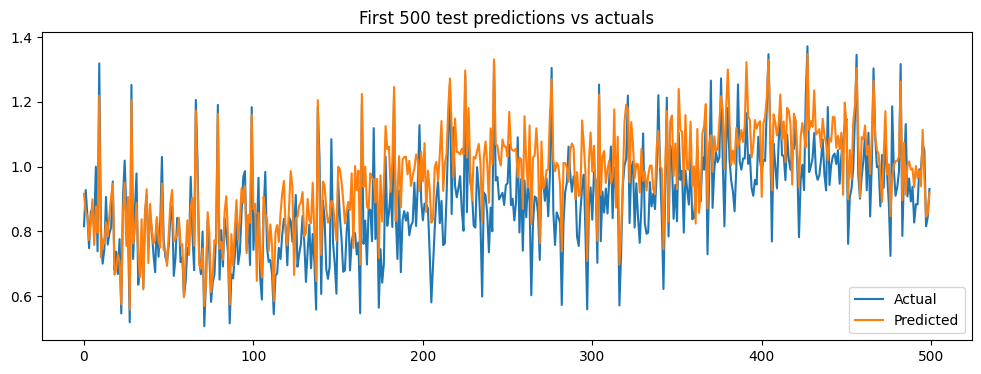

Test error l: 0.5163801765716156
Test error r: 0.4019899555538581
Test error m: 0.6196857555354871

Test Year: 2023 | Training Years: 2021 to 2022
Train samples: 534866 | Test samples: 289771


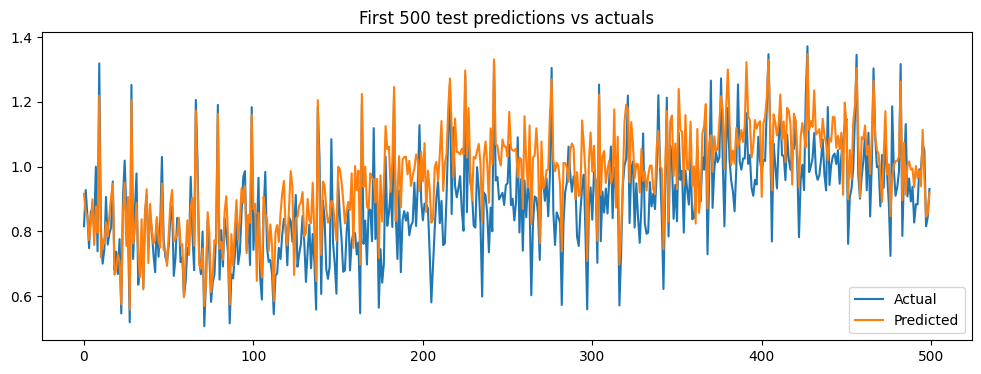

Test error l: 0.668731324944287
Test error r: 0.3507263527500073
Test error m: 0.44227249413355696

Test Year: 2024 | Training Years: 2022 to 2023
Train samples: 572628 | Test samples: 303966


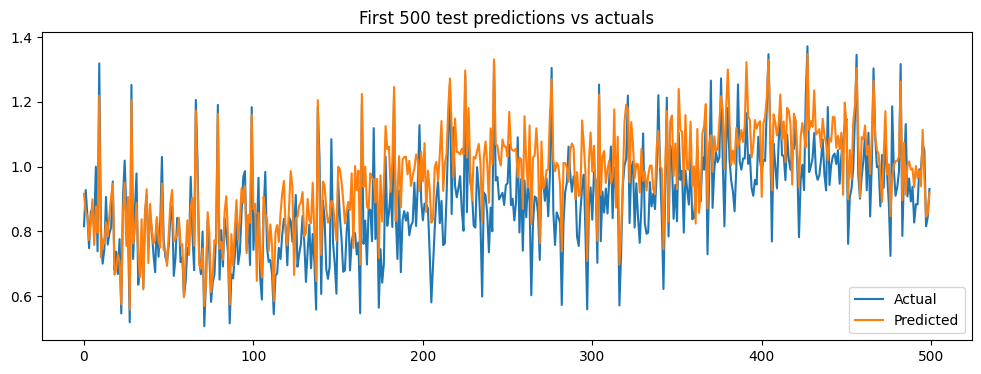

Test error l: 0.6857926228944908
Test error r: 0.09152505578417258
Test error m: 0.6228831115556474
Overall Train Metrics:
MAE: 0.04108730414091114, RMSE: 0.05649817809455532, R²: 0.9129978736603788
Overall Test Metrics:
MAE: 0.0862063214126359, RMSE: 0.11820393371813998, R²: 0.6325645422533008
================== DoubleMLPLIV Object ==================

------------------ Data summary      ------------------
Outcome variable: consumption_normalized
Treatment variable(s): ['DayAheadPriceEUR']
Cluster variable(s): ['Country']
Covariates: ['HourOfWeek_149', 'block_1.0:tempbin2', 'HourOfWeek_150', 'HourOfWeek_125', 'block_6.0:tempbin2', 'HourOfWeek_126', 'HourOfWeek_151', 'HourOfWeek_157', 'HourOfWeek_156', 'HourOfWeek_158', 'HourOfWeek_155', 'HourOfWeek_154', 'HourOfWeek_140', 'HourOfWeek_153', 'HourOfWeek_164', 'HourOfWeek_159', 'HourOfWeek_132', 'HourOfWeek_152', 'HourOfWeek_32', 'HourOfWeek_133', 'HourOfWeek_56', 'HourOfWeek_134', 'HourOfWeek_131', 'HourOfWeek_80', 'HourOfWeek_104', 'Ho

In [62]:
dml_pliv_obj_lags_imp_1, filtered_data_lags_imp_1, importance_df_lags_imp_1, fold_metrics_df_lags_imp_1, importance_all_folds_df_lags_imp_1, fold_coefficients_lags_imp_1 = dml_rolling_window(processed_data, 
                                                                                                                             important_features, 
                                                                                                                             param_dist_xgb=param_dist_xgb,
                                                                                                                             dependent_variable = 'consumption_normalized')
          

# Nuancies

## CIV(Wt,...,Wt−26 | (Pt,Dt−1) → Dt | ∅)

In [10]:
def prepare_data_lags_with_iv_lags(
    data,
    base_covariates=None,
    include_interactions=None,
    dependent_variable='consumption_normalized',
    include_lags=True,
    lag_variable='Total_Wind_Generation',
    n_lags=50
):
    data = data.copy()
    data = data[data["PriceArea"] != "DE_AT_LU"]
    data['Time'] = pd.to_datetime(data['Time'])
    data['Year'] = data['Time'].dt.year
    data = data.sort_values(by='Time')
    data['Country'] = data['PriceArea']
    data['consumption_normalized'] = (
        data['ConsumptionValue'] / 
        data.groupby(['Country', data['Time'].dt.year])['ConsumptionValue'].transform('mean')
    )
    data['consumption_norm_peak'] = (
        data['ConsumptionValue'] / 
        data.groupby(['Country', 'Year'])['ConsumptionValue'].transform('max')
    )

    data['Total_Wind_Generation'] = (
        data['Wind_Offshore'].fillna(0) + data['Wind_Onshore'].fillna(0)
    )

    # Dummies
    data = pd.get_dummies(data, columns=['block'], drop_first=False)
    data = pd.get_dummies(data, columns=['PriceArea'], drop_first=False)
    price_area_columns = [col for col in data.columns if col.startswith('PriceArea_')]
    for col in price_area_columns:
        data[col] = data[col].astype(int)

    data['HourOfWeek'] = data['Time'].dt.dayofweek * 24 + data['Time'].dt.hour
    data = pd.get_dummies(data, columns=['HourOfWeek'], drop_first=False)

    data['Month'] = data['Time'].dt.month
    data = pd.get_dummies(data, columns=['Month'], drop_first=False)

    # Rolling features
    data['RollingMean24h'] = (
        data.groupby(['Country', 'Year'])[dependent_variable]
        .transform(lambda x: x.rolling(window=24, min_periods=12).mean())
    )
    data['RollingStd24h_Price'] = (
        data.groupby(['Country', 'Year'])['DayAheadPriceEUR']
        .transform(lambda x: x.rolling(window=24, min_periods=12).std())
    )

    # Weekend / spike flags
    data['IsWeekend'] = (data['Time'].dt.dayofweek >= 5).astype(int)

    # Step 2: Add interaction terms if specified
    interaction_covariates = []
    block_dummy_columns = [col for col in data.columns if col.startswith('block_')]

    if include_interactions:
        for block_col in block_dummy_columns:
            if 'block' in include_interactions:
                for interaction_col in include_interactions['block']:
                    interaction_term = f'{block_col}:{interaction_col}'
                    data[interaction_term] = data[block_col] * data[interaction_col]
                    interaction_covariates.append(interaction_term)

    # Step 3: Add lagged instruments
    lagged_iv_columns = []
    if include_lags:
        for lag in range(1, n_lags + 1):
            lag_col = f'{lag_variable}_lag{lag}'
            data[lag_col] = data.groupby('Country')[lag_variable].transform(lambda x: x.shift(lag))
            lagged_iv_columns.append(lag_col)

    # Add one lag of dependent variable
    data[f'{dependent_variable}_lag1'] = (
        data.groupby('Country')[dependent_variable].transform(lambda x: x.shift(1))
    )

    # Create full covariate list
    covariates = list(set(base_covariates + interaction_covariates +
                          [col for col in data.columns if col.startswith('PriceArea_')] +
                          [col for col in data.columns if col.startswith('HourOfWeek_')] +
                          [col for col in data.columns if col.startswith('Month_')] +
                          [f'{dependent_variable}_lag1']))

    covariates = [col for col in covariates if not (col.startswith('block_') and ':' not in col)]
    endogenous_variable = 'DayAheadPriceEUR'
    instrument_variables = ['Total_Wind_Generation'] + lagged_iv_columns

    key_variables = [dependent_variable, endogenous_variable] + instrument_variables + covariates
    filtered_processed_data = data.dropna(subset=key_variables)

    return filtered_processed_data, covariates, instrument_variables

In [11]:
processed_data, covariates, instrument_variables = prepare_data_lags_with_iv_lags(
    data_1,
    base_covariates=['Price_gas', 'Price_coal', 'Price_EUA'],
    include_interactions={'block': ['tempbin', 'tempbin2', 'Solar_MWh']},
    dependent_variable = 'consumption_normalized'
)
processed_data = processed_data[processed_data['Time'].dt.year != 2025]

<ipython-input-10-da95fb025682>:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[lag_col] = data.groupby('Country')[lag_variable].transform(lambda x: x.shift(lag))
<ipython-input-10-da95fb025682>:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[lag_col] = data.groupby('Country')[lag_variable].transform(lambda x: x.shift(lag))
<ipython-input-10-da95fb025682>:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

<ipython-input-10-da95fb025682>:76: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{dependent_variable}_lag1'] = (


In [12]:
instrument_variables

['Total_Wind_Generation',
 'Total_Wind_Generation_lag1',
 'Total_Wind_Generation_lag2',
 'Total_Wind_Generation_lag3',
 'Total_Wind_Generation_lag4',
 'Total_Wind_Generation_lag5',
 'Total_Wind_Generation_lag6',
 'Total_Wind_Generation_lag7',
 'Total_Wind_Generation_lag8',
 'Total_Wind_Generation_lag9',
 'Total_Wind_Generation_lag10',
 'Total_Wind_Generation_lag11',
 'Total_Wind_Generation_lag12',
 'Total_Wind_Generation_lag13',
 'Total_Wind_Generation_lag14',
 'Total_Wind_Generation_lag15',
 'Total_Wind_Generation_lag16',
 'Total_Wind_Generation_lag17',
 'Total_Wind_Generation_lag18',
 'Total_Wind_Generation_lag19',
 'Total_Wind_Generation_lag20',
 'Total_Wind_Generation_lag21',
 'Total_Wind_Generation_lag22',
 'Total_Wind_Generation_lag23',
 'Total_Wind_Generation_lag24',
 'Total_Wind_Generation_lag25',
 'Total_Wind_Generation_lag26',
 'Total_Wind_Generation_lag27',
 'Total_Wind_Generation_lag28',
 'Total_Wind_Generation_lag29',
 'Total_Wind_Generation_lag30',
 'Total_Wind_Generation

In [13]:
covariates

['HourOfWeek_84',
 'HourOfWeek_94',
 'PriceArea_EE',
 'HourOfWeek_147',
 'HourOfWeek_62',
 'block_1.0:tempbin2',
 'HourOfWeek_143',
 'HourOfWeek_55',
 'PriceArea_IT_CALA',
 'HourOfWeek_50',
 'HourOfWeek_126',
 'block_2.0:tempbin',
 'HourOfWeek_38',
 'HourOfWeek_110',
 'HourOfWeek_16',
 'HourOfWeek_79',
 'Month_7',
 'HourOfWeek_27',
 'block_6.0:Solar_MWh',
 'Month_6',
 'HourOfWeek_63',
 'HourOfWeek_66',
 'HourOfWeek_81',
 'HourOfWeek_98',
 'HourOfWeek_124',
 'HourOfWeek_130',
 'block_3.0:tempbin',
 'HourOfWeek_135',
 'HourOfWeek_75',
 'HourOfWeek_31',
 'HourOfWeek_78',
 'PriceArea_PT',
 'HourOfWeek_3',
 'HourOfWeek_116',
 'HourOfWeek_140',
 'HourOfWeek_163',
 'Month_5',
 'HourOfWeek_148',
 'HourOfWeek_4',
 'PriceArea_NO_1',
 'HourOfWeek_61',
 'block_4.0:tempbin2',
 'block_4.0:Solar_MWh',
 'HourOfWeek_102',
 'HourOfWeek_44',
 'PriceArea_AT',
 'PriceArea_DK_1',
 'HourOfWeek_83',
 'HourOfWeek_52',
 'HourOfWeek_58',
 'HourOfWeek_152',
 'HourOfWeek_33',
 'block_4.0:tempbin',
 'HourOfWeek_70'

In [14]:
def dml_rolling_window_lagged_instruments(
    filtered_data,
    base_covariates,
    instrument_variables,
    lag_variable='Total_Wind_Generation',
    n_lags=50,
    manual_params_l=None,
    manual_params_r=None,
    manual_params_m=None,
    param_dist_xgb=None,
    param_dist_xgb_r=None,
    param_dist_xgb_m=None,
    dependent_variable='consumption_normalized'):

    data = filtered_data.copy()
    covariates = base_covariates.copy()

    train_test_pairs = [
        (2015, 2016, 2017), (2016, 2017, 2018), (2017, 2018, 2019),
        (2018, 2019, 2020), (2019, 2020, 2021), (2020, 2021, 2022),
        (2021, 2022, 2023), (2022, 2023, 2024)
    ]

    def tune_xgb_model(X, y, param_grid):
        tscv = TimeSeriesSplit(n_splits=3)
        model = xgb.XGBRegressor(objective="reg:squarederror", tree_method="gpu_hist", eval_metric="rmse")
        grid_search = GridSearchCV(model, param_grid, cv=tscv, n_jobs=-1)
        grid_search.fit(X, y)
        return grid_search.best_params_
    
    best_params_xgb = None  # Store best params from first window
    best_params_xgb_treat = None
    best_params_xgb_inst = None
    lasso_param = None

    data['Year'] = data['Time'].dt.year
    year_to_indices = data.groupby('Year').indices

    predictions_ml_l, predictions_ml_r = [], []
    predictions_ml_m_dict = {
        f'ml_m_{lag_variable}': [],  # Include original instrument
        **{f'ml_m_{lag_variable}_lag{i}': [] for i in range(1, n_lags + 1)}
    }
    time_indices, train_predictions, train_actuals, test_predictions, test_actuals = [], [], [], [], []
    feature_importances_per_window, fold_metrics, fold_feature_importance_df, fold_coefficients = [], [], [], []
    
    for train_start, train_end, test_year in train_test_pairs:
        train_indices = []
        for y in range(train_start, train_end + 1):
            if y in year_to_indices:
                train_indices.extend(year_to_indices[y])

        test_indices = year_to_indices.get(test_year, [])

        if len(train_indices) == 0 or len(test_indices) == 0:
            print(f"Skipping test year {test_year} due to insufficient data.")
            continue
        
        train_data = data.iloc[train_indices]
        test_data = data.iloc[test_indices]

        print(f"\nTest Year: {test_year} | Training Years: {train_start} to {train_end}")
        print(f"Train samples: {len(train_indices)} | Test samples: {len(test_indices)}")

        X_train = train_data[covariates]
        y_train = train_data[dependent_variable]
        d_train = train_data['DayAheadPriceEUR']
        X_test = test_data[covariates]
        y_test = test_data[dependent_variable]
        d_test = test_data['DayAheadPriceEUR']
        
        if 'best_params_l' not in locals() and manual_params_l is None:
            best_params_l = tune_xgb_model(X_train, y_train, param_dist_xgb)
            print("Best L Parameters:", best_params_l)
            
        if 'best_params_r' not in locals() and manual_params_r is None:
            best_params_r = tune_xgb_model(X_train, d_train, param_dist_xgb_r)
            print("Best R Parameters:", best_params_r)
                
        learner_l = xgb.XGBRegressor(**(manual_params_l if manual_params_l else best_params_l))
        learner_r = xgb.XGBRegressor(**(manual_params_r if manual_params_r else best_params_r))
        learner_l.fit(X_train, y_train)
        learner_r.fit(X_train, d_train)

        pred_l = learner_l.predict(X_test)
        pred_r = learner_r.predict(X_test)
        
        if 'best_params_m' not in locals() and manual_params_m is None:
            best_params_m = tune_xgb_model(X_train, train_data[lag_variable], param_dist_xgb_m)
            print("Best M Parameters (for all lags):", best_params_m)
            
        learner_m = xgb.XGBRegressor(**(manual_params_m if manual_params_m else best_params_m))
        learner_m.fit(X_train, train_data[lag_variable])
        pred_m_main = learner_m.predict(X_test)
        predictions_ml_m_dict[f'ml_m_{lag_variable}'].extend(pred_m_main)
        
        for i in range(1, n_lags + 1):
            instr_col = f'{lag_variable}_lag{i}'
            learner_m_lag = xgb.XGBRegressor(**(manual_params_m if manual_params_m else best_params_m))
            learner_m_lag.fit(X_train, train_data[instr_col])
            pred_lag = learner_m_lag.predict(X_test)
            predictions_ml_m_dict[f'ml_m_{instr_col}'].extend(pred_lag)

        predictions_ml_l.extend(pred_l)
        predictions_ml_r.extend(pred_r)
        time_indices.extend(test_data.index.tolist())

        train_predictions.extend(learner_l.predict(X_train))
        train_actuals.extend(y_train)
        test_predictions.extend(pred_l)
        test_actuals.extend(y_test)
        
                
        plt.figure(figsize=(12, 4))
        plt.plot(test_actuals[:500], label='Actual')
        plt.plot(test_predictions[:500], label='Predicted')
        plt.title("First 500 test predictions vs actuals")
        plt.legend()
        plt.show()

        feature_importances_per_window.append(learner_l.feature_importances_)

        fold_metrics.append({
            'Test Year': test_year,
            'MAE': mean_absolute_error(y_test, pred_l),
            'RMSE': mean_squared_error(y_test, pred_l, squared=False),
            'R2': r2_score(y_test, pred_l)
        })

        fold_feature_importance_df.append(pd.DataFrame({
            'Feature': covariates,
            'Importance': learner_l.feature_importances_,
            'Year': test_year
        }))

        dml_data = dml.DoubleMLClusterData(
            test_data.reset_index(drop=True),
            y_col=dependent_variable,
            d_cols='DayAheadPriceEUR',
            z_cols=instrument_variables,
            x_cols=covariates,
            cluster_cols=['Country']
        )

        dml_fold = dml.DoubleMLPLIV(
            dml_data,
            dml.utils.DMLDummyRegressor(),
            dml.utils.DMLDummyRegressor(),
            dml.utils.DMLDummyRegressor()
        )

        external_preds = {
            'DayAheadPriceEUR': {
                'ml_l': np.array(pred_l).reshape(-1, 1),
                'ml_r': np.array(pred_r).reshape(-1, 1)
            }
        }
        for k, v in predictions_ml_m_dict.items():
            external_preds['DayAheadPriceEUR'][k] = np.array(v[-len(pred_l):]).reshape(-1, 1)

        dml_fold.fit(external_predictions=external_preds)

        fold_coefficients.append({
            'Year': test_year,
            'coef': dml_fold.coef,
            'se': dml_fold.se,
            't': dml_fold.t_stat,
            'p': dml_fold.pval
        })

    train_mae = mean_absolute_error(train_actuals, train_predictions)
    train_rmse = mean_squared_error(train_actuals, train_predictions, squared=False)
    train_r2 = r2_score(train_actuals, train_predictions)

    test_mae = mean_absolute_error(test_actuals, test_predictions)
    test_rmse = mean_squared_error(test_actuals, test_predictions, squared=False)
    test_r2 = r2_score(test_actuals, test_predictions)

    print("Overall Train Metrics:")
    print(f"MAE: {train_mae}, RMSE: {train_rmse}, R²: {train_r2}")
    print("Overall Test Metrics:")
    print(f"MAE: {test_mae}, RMSE: {test_rmse}, R²: {test_r2}")

    feature_importances_array = np.array(feature_importances_per_window)
    importance_df = pd.DataFrame({
        'Feature': covariates,
        'Mean Importance': feature_importances_array.mean(axis=0),
        'Std Importance': feature_importances_array.std(axis=0)
    }).sort_values(by='Mean Importance', ascending=False)

    filtered_data_final = data.loc[data.index.isin(time_indices)].copy()

    external_pred_dict = {
        'DayAheadPriceEUR': {
            'ml_l': np.array(predictions_ml_l).reshape(-1, 1),
            'ml_r': np.array(predictions_ml_r).reshape(-1, 1)
        }
    }
    for k, v in predictions_ml_m_dict.items():
        external_pred_dict['DayAheadPriceEUR'][k] = np.array(v).reshape(-1, 1)

    obj_dml_data = dml.DoubleMLClusterData(
        filtered_data_final,
        y_col=dependent_variable,
        d_cols='DayAheadPriceEUR',
        z_cols=instrument_variables,
        x_cols=covariates,
        cluster_cols=['Country']
    )

    dml_pliv_obj = dml.DoubleMLPLIV(obj_dml_data, dml.utils.DMLDummyRegressor(), dml.utils.DMLDummyRegressor(), dml.utils.DMLDummyRegressor())
    dml_pliv_obj.fit(external_predictions=external_pred_dict)

    filtered_data_final['Prrediction'] = dml_pliv_obj.predictions['ml_l'].ravel()
    filtered_data_final['Residuals'] = dml_pliv_obj.predictions['ml_l'].ravel() - filtered_data_final[dependent_variable]

    importance_all_folds_df = pd.concat(fold_feature_importance_df, ignore_index=True)
    fold_metrics_df = pd.DataFrame(fold_metrics)

    return dml_pliv_obj, filtered_data_final, importance_df, fold_metrics_df, importance_all_folds_df, fold_coefficients


In [15]:
param_dist_xgb = {
    'learning_rate': [0.01, 0.02],
    'max_depth': [4, 5],
    'n_estimators': [300, 400],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}
param_dist_xgb_r = {
    'learning_rate': [0.01],
    'max_depth': [2, 3],
    'n_estimators': [200, 300],
    'subsample': [0.7],
    'colsample_bytree': [0.7, 0.8],
    'reg_alpha': [0.0, 0.1],   # no regularization vs. mild
    'reg_lambda': [0.3, 0.5]
}
param_dist_xgb_m = {
    'learning_rate': [0.01],
    'max_depth': [3, 4],
    'n_estimators': [300, 400],
    'subsample': [0.9],
    'colsample_bytree': [0.9]
}

In [16]:
sample_data = processed_data.sample(n=1000, random_state=42)
sample_data

Unnamed: 0                Time  ConsumptionValue  \
Unnamed: 0.1                                                     
2246776.0      3141011.0 2024-03-21 02:00:00            1303.0   
975265.0       1464306.0 2019-05-29 15:00:00            1811.0   
1592211.0      2343112.0 2021-12-11 16:00:00            5983.0   
518114.0             NaN 2017-05-11 15:00:00           65106.0   
730165.0       1087475.0 2018-04-21 06:00:00            4766.0   
...                  ...                 ...               ...   
36957.0          56221.0 2015-03-06 03:00:00             752.0   
618297.0        916464.0 2017-10-19 07:00:00            6140.0   
915151.0       1371743.0 2019-02-22 04:00:00           11667.0   
1115131.0      1675494.0 2020-01-04 23:00:00            1695.0   
1486210.0      2198711.0 2021-07-13 18:00:00           30417.0   

              DayAheadPriceEUR  WeatherWindSpeed  WeatherTemperature  Year  \
Unnamed: 0.1                                                                 
2246776.0                66.93          3.723962          279.897766  2024   
975265.0                 45.17          5.950732          284.626770  2019   
1592211.0               281.59          4.319129          288.164398  2021   
518114.0                 34.80          6.807398          291.030884  2017   
730165.0                 59.11          3.341413          288.213928  2018   
...                        ...               ...                 ...   ...   
36957.0                  35.31         15.342645          282.092529  2015   
618297.0                 68.79          1.971406          291.748993  2017   
915151.0                 42.00          3.934189          279.890991  2019   
1115131.0                44.00          6.918842          284.856140  2020   
1486210.0                98.97          5.829161          294.436035  2021   

               Day  Hour  WeatherTemperature_F  ...  \
Unnamed: 0.1                                    ...   
2246776.0     21.0   2.0             44.145979  ...   
975265.0      29.0  15.0             52.658186  ...   
1592211.0     11.0  16.0             59.025917  ...   
518114.0      11.0  15.0             64.185591  ...   
730165.0      21.0   6.0             59.115071  ...   
...            ...   ...                   ...  ...   
36957.0        6.0   3.0             48.096553  ...   
618297.0      19.0   7.0             65.478187  ...   
915151.0      22.0   4.0             44.133784  ...   
1115131.0      4.0  23.0             53.071052  ...   
1486210.0     13.0  18.0             70.314863  ...   

              Total_Wind_Generation_lag42  Total_Wind_Generation_lag43  \
Unnamed: 0.1                                                             
2246776.0                            1.00                          2.0   
975265.0                             0.00                          0.0   
1592211.0                         3684.00                       3747.0   
518114.0                          3288.25                       3248.5   
730165.0                           224.00                        247.0   
...                                   ...                          ...   
36957.0                             18.00                         24.0   
618297.0                           860.00                        889.0   
915151.0                          1189.00                       1132.0   
1115131.0                          249.00                        265.0   
1486210.0                         8601.00                       8385.0   

              Total_Wind_Generation_lag44 Total_Wind_Generation_lag45  \
Unnamed: 0.1                                                            
2246776.0                             1.0                        1.00   
975265.0                              0.0                        0.00   
1592211.0                          3512.0                     3273.00   
518114.0                           3611.0                     3926.25   
730165.0               


Test Year: 2017 | Training Years: 2015 to 2016
Train samples: 178 | Test samples: 91
Best L Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.8}


/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
55 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/.local/lib/python3.8/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/.local/lib/python3.8/site-packages/xgboost/sklearn.py", line 1025, in fit
    self._Booster = train(
  File "/.local/lib/python3.8/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwarg

Best R Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 300, 'reg_alpha': 0.0, 'reg_lambda': 0.5, 'subsample': 0.7}


/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1 fits failed out of a total of 12.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/.local/lib/python3.8/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/.local/lib/python3.8/site-packages/xgboost/sklearn.py", line 988, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/.local/lib/python3.8/site-packages/xgboost/sklearn.py", line 448, in _wr

Best M Parameters (for all lags): {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 400, 'subsample': 0.9}


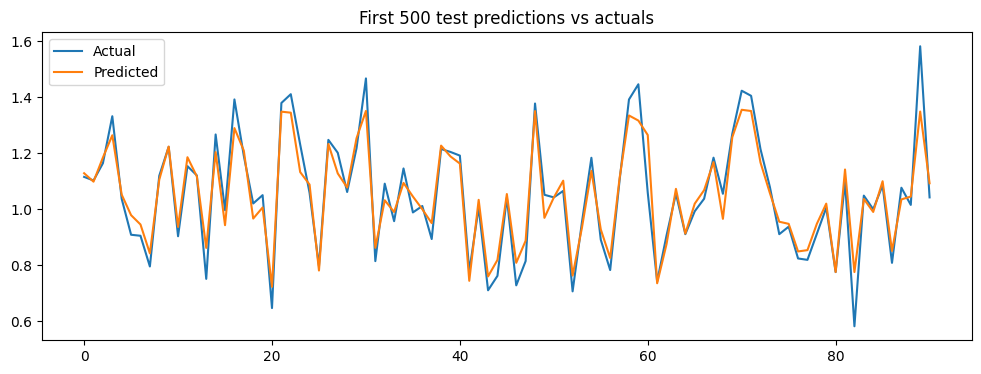


Test Year: 2018 | Training Years: 2016 to 2017
Train samples: 188 | Test samples: 92


In [ ]:
dml_pliv_obj_nuances, filtered_data_nuances, importance_df_nuances, fold_metrics_df_nuances, importance_all_folds_df_nuances, fold_coefficients_nuances = dml_rolling_window_lagged_instruments(
    sample_data,
    covariates,
    instrument_variables,  
    lag_variable='Total_Wind_Generation',
    n_lags=50,
    param_dist_xgb=param_dist_xgb,
    param_dist_xgb_r=param_dist_xgb_r,
    param_dist_xgb_m=param_dist_xgb_m,
    dependent_variable='consumption_normalized')
          

# Better prediction

In [29]:
def prepare_data_with_dummies_and_interactions(
    data,
    base_covariates=None,
    include_interactions=None,
    dependent_variable='consumption_normalized',
    include_lags=True
):
    data = data.copy()
    data = data[data["PriceArea"] != "DE_AT_LU"]
    data['Time'] = pd.to_datetime(data['Time'])
    data['Year'] = data['Time'].dt.year
    data = data.sort_values(by='Time')
    data['Country'] = data['PriceArea']
    data['consumption_normalized'] = (
        data['ConsumptionValue'] / 
        data.groupby(['Country', data['Time'].dt.year])['ConsumptionValue'].transform('mean')
    )
    data['consumption_norm_peak'] = (
        data['ConsumptionValue'] / 
        data.groupby(['Country', 'Year'])['ConsumptionValue'].transform('max')
    )

    data['Total_Wind_Generation'] = (
        data['Wind_Offshore'].fillna(0) + data['Wind_Onshore'].fillna(0)
    )

    # Dummies
    data = pd.get_dummies(data, columns=['block'], drop_first=False)
    data = pd.get_dummies(data, columns=['PriceArea'], drop_first=False)
    price_area_columns = [col for col in data.columns if col.startswith('PriceArea_')]
    for col in price_area_columns:
        data[col] = data[col].astype(int)

    data['HourOfWeek'] = data['Time'].dt.dayofweek * 24 + data['Time'].dt.hour
    data = pd.get_dummies(data, columns=['HourOfWeek'], drop_first=False)

    data['Month'] = data['Time'].dt.month
    data = pd.get_dummies(data, columns=['Month'], drop_first=False)

    # Rolling features
    data['RollingMean24h'] = (
        data.groupby(['Country', 'Year'])['ConsumptionValue']
        .transform(lambda x: x.rolling(window=24, min_periods=12).mean())
    )
    data['Lag1_Price'] = data.groupby('Country')['DayAheadPriceEUR'].shift(1)
    data['RollingStd24_LaggedPrice'] = data.groupby(['Country', 'Year'])['Lag1_Price'].transform(
        lambda x: x.rolling(window=24, min_periods=12).std()
    )
    price_threshold = data['Lag1_Price'].quantile(0.95)
    data['LaggedPriceSpike'] = (data['Lag1_Price'] > price_threshold).astype(int)


    # Step 2: Add interaction terms if specified
    interaction_covariates = []
    block_dummy_columns = [col for col in data.columns if col.startswith('block_')]

    if include_interactions:
        for block_col in block_dummy_columns:
            if 'block' in include_interactions:
                for interaction_col in include_interactions['block']:
                    interaction_term = f'{block_col}:{interaction_col}'
                    data[interaction_term] = data[block_col] * data[interaction_col]
                    interaction_covariates.append(interaction_term)

    # Step 3: Optionally add lagged features
    lag_features = []
    if include_lags:
        data['Lag1_Consumption'] = data.groupby('Country')[dependent_variable].shift(1)
        data['Lag24_Consumption'] = data.groupby('Country')[dependent_variable].shift(24)
        data['Lag168_Consumption'] = data.groupby('Country')[dependent_variable].shift(168)
        lag_features = ['Lag1_Consumption', 'Lag24_Consumption', 'Lag168_Consumption']

    # Step 4: Define covariates
    if base_covariates is None:
        base_covariates = []

    engineered_features = ['RollingStd24_LaggedPrice', 'LaggedPriceSpike']
    all_features = base_covariates + engineered_features + lag_features

    for feat in all_features:
        if feat not in base_covariates:
            base_covariates.append(feat)

    covariates = list(set(base_covariates + interaction_covariates +
                          [col for col in data.columns if col.startswith('PriceArea_')] +
                          [col for col in data.columns if col.startswith('HourOfWeek_')] +
                          [col for col in data.columns if col.startswith('Month_')]))

    covariates = [col for col in covariates if not (col.startswith('block_') and ':' not in col)]

    endogenous_variable = 'DayAheadPriceEUR'
    instrument_variables = ['Total_Wind_Generation']

    key_variables = [dependent_variable, endogenous_variable] + instrument_variables + covariates
    filtered_processed_data = data.dropna(subset=key_variables)

    return filtered_processed_data, covariates

In [30]:
processed_data_new, covariates_new = prepare_data_with_dummies_and_interactions(
    data_1,
    base_covariates=['Price_gas', 'Price_coal', 'Price_EUA'],
    include_interactions={'block': ['tempbin', 'tempbin2', 'Solar_MWh']},
    dependent_variable = 'consumption_normalized'
)

In [31]:
processed_data_new = processed_data_new[processed_data_new['Time'].dt.year != 2025]

In [32]:
param_dist_xgb = {
    'learning_rate': [0.01, 0.02],
    'max_depth': [4, 5],
    'n_estimators': [300, 400],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}
param_dist_xgb_r = {
    'learning_rate': [0.01],
    'max_depth': [2, 3],
    'n_estimators': [200, 300],
    'subsample': [0.7],
    'colsample_bytree': [0.7, 0.8],
    'reg_alpha': [0.0, 0.1],   # no regularization vs. mild
    'reg_lambda': [0.3, 0.5]
}
param_dist_xgb_m = {
    'learning_rate': [0.01],
    'max_depth': [3, 4],
    'n_estimators': [300, 400],
    'subsample': [0.9],
    'colsample_bytree': [0.9]
}


Test Year: 2017 | Training Years: 2015 to 2016
Train samples: 397533 | Test samples: 209691
Best L Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.02, 'max_depth': 5, 'n_estimators': 400, 'subsample': 0.8}
Best R Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 0.5, 'subsample': 0.7}
Best M Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.9}


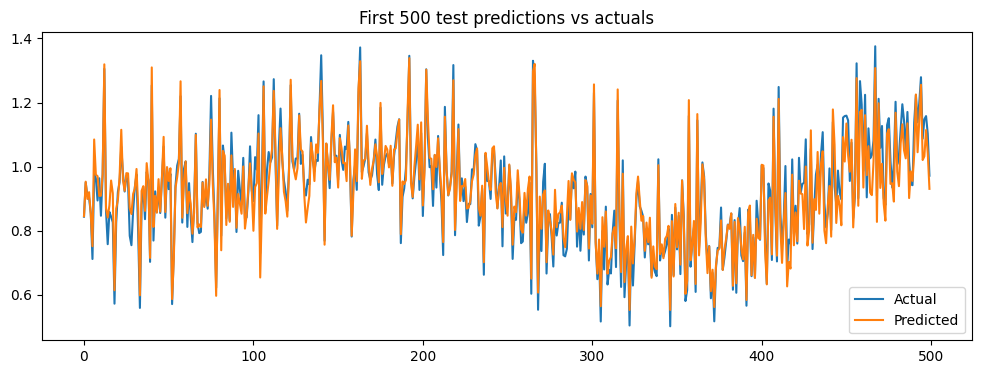

Test error l: 0.9726772642102132
Test error r: 0.31251295852330263
Test error m: 0.5848198450409832

Test Year: 2018 | Training Years: 2016 to 2017
Train samples: 411612 | Test samples: 202944


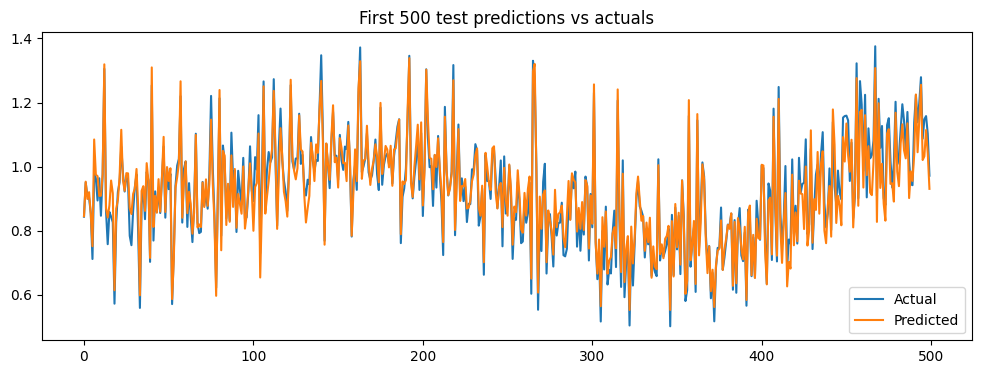

Test error l: 0.9704691198512815
Test error r: -0.07462118094293646
Test error m: 0.6440529988410805

Test Year: 2019 | Training Years: 2017 to 2018
Train samples: 412635 | Test samples: 220672


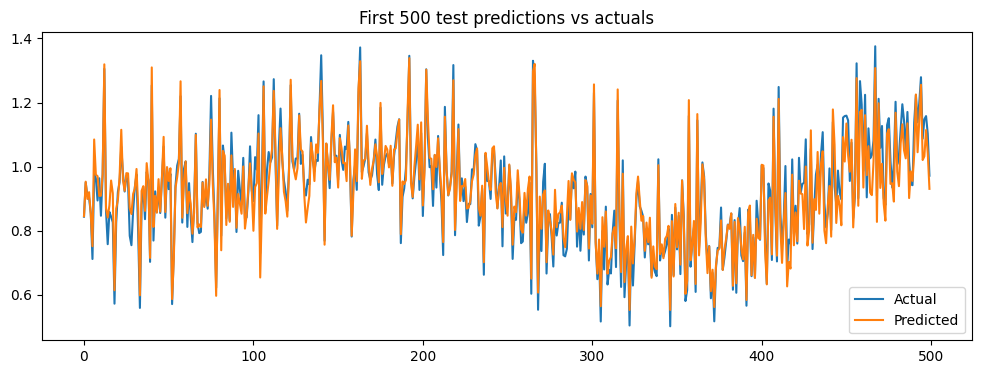

Test error l: 0.9729746318084385
Test error r: 0.3076439511335406
Test error m: 0.6007556718591616

Test Year: 2020 | Training Years: 2018 to 2019
Train samples: 423616 | Test samples: 234271


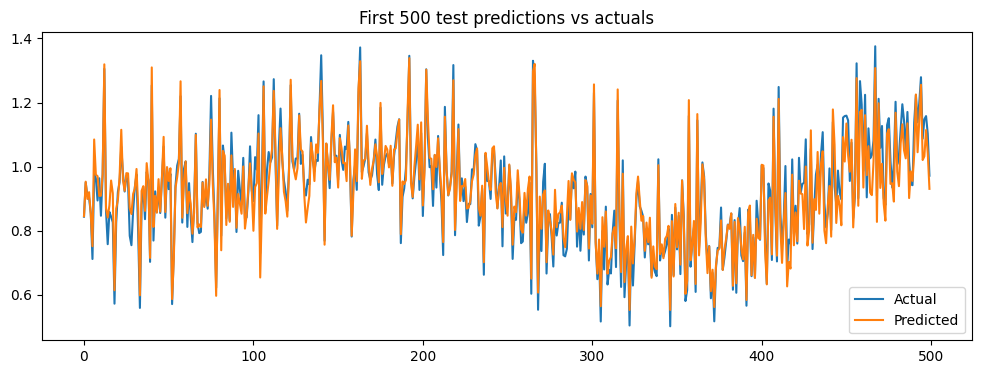

Test error l: 0.9756273949508811
Test error r: 0.1923932655498558
Test error m: 0.6132948017964268

Test Year: 2021 | Training Years: 2019 to 2020
Train samples: 454943 | Test samples: 250886


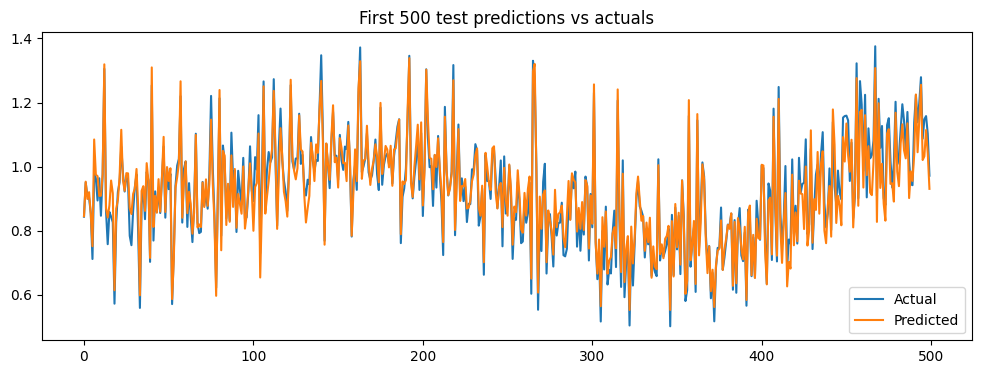

Test error l: 0.9572423317422655
Test error r: -0.4726520461460162
Test error m: 0.5931904154027201

Test Year: 2022 | Training Years: 2020 to 2021
Train samples: 485157 | Test samples: 282483


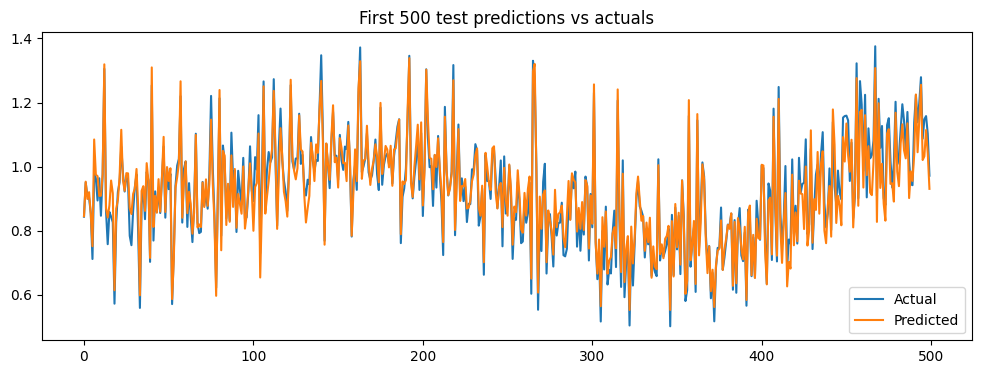

Test error l: 0.9624619702472135
Test error r: 0.5709556080646132
Test error m: 0.6198683088358747

Test Year: 2023 | Training Years: 2021 to 2022
Train samples: 533369 | Test samples: 289183


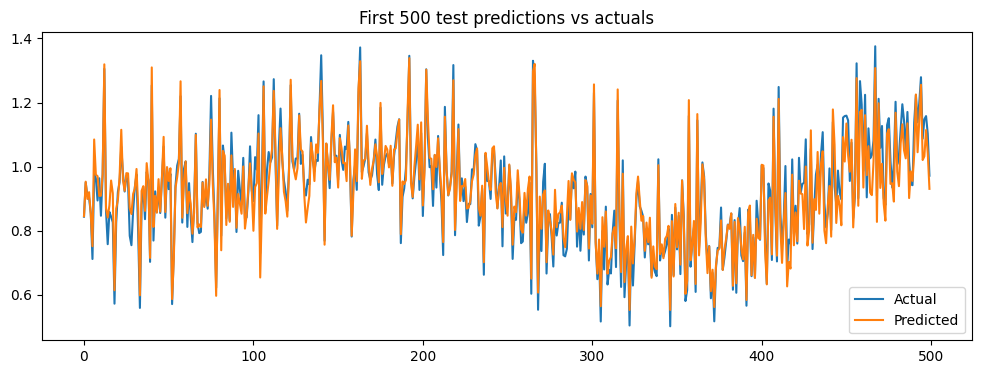

Test error l: 0.9609558018034291
Test error r: 0.21938943777477504
Test error m: 0.5904199105759753

Test Year: 2024 | Training Years: 2022 to 2023
Train samples: 571666 | Test samples: 303356


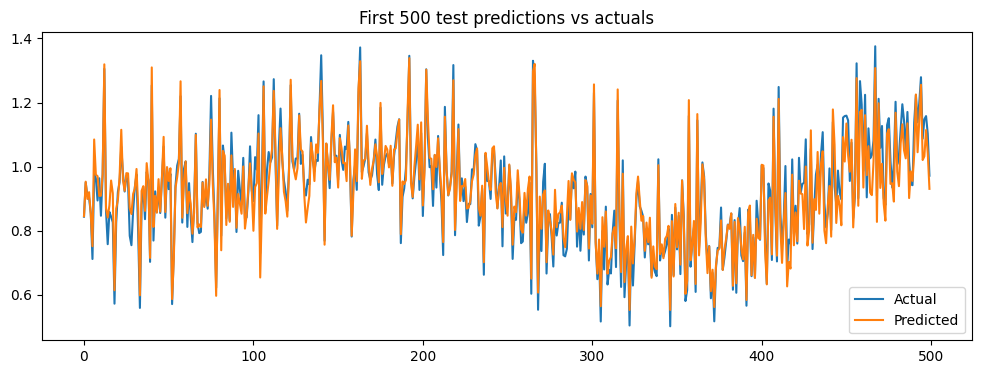

Test error l: 0.9614050221909093
Test error r: 0.34957647726470764
Test error m: 0.6039702952532304
Overall Train Metrics:
MAE: 0.023533871493136533, RMSE: 0.03289763844541965, R²: 0.9704803045720747
Overall Test Metrics:
MAE: 0.02492713364395984, RMSE: 0.03606293670910877, R²: 0.9657760795730171
================== DoubleMLPLIV Object ==================

------------------ Data summary      ------------------
Outcome variable: consumption_normalized
Treatment variable(s): ['DayAheadPriceEUR']
Cluster variable(s): ['Country']
Covariates: ['HourOfWeek_107', 'block_5.0:tempbin', 'HourOfWeek_33', 'HourOfWeek_142', 'HourOfWeek_138', 'HourOfWeek_146', 'HourOfWeek_147', 'HourOfWeek_47', 'HourOfWeek_120', 'HourOfWeek_81', 'HourOfWeek_139', 'block_2.0:tempbin2', 'HourOfWeek_41', 'HourOfWeek_137', 'HourOfWeek_31', 'PriceArea_LT', 'HourOfWeek_101', 'HourOfWeek_32', 'HourOfWeek_116', 'HourOfWeek_132', 'HourOfWeek_57', 'HourOfWeek_76', 'HourOfWeek_82', 'HourOfWeek_74', 'LaggedPriceSpike', 'HourOfWe

In [33]:
dml_pliv_obj_new, filtered_data_new, importance_df_new, fold_metrics_df_new, importance_all_folds_df_new, fold_coefficients_new = dml_rolling_window(processed_data_new, 
                                                                                                                             covariates_new, 
                                                                                                                             dependent_variable = 'consumption_normalized',
                                                                                                                             param_dist_xgb=param_dist_xgb,
                                                                                                                             param_dist_xgb_r=param_dist_xgb_r,
                                                                                                                             param_dist_xgb_m=param_dist_xgb_m)
          

In [34]:
filtered_data_new.to_csv("new_model.csv", index=False)
importance_df_new.to_csv("new_model_importance_df.csv", index=False)
fold_coefficients_new = pd.DataFrame(fold_coefficients_new)
fold_coefficients_new.to_csv("new_model_fold_coefficients.csv", index=False)

In [35]:
covariates_regression = [var for var in covariates_new if var not in ['HourOfWeek_0', 'Month_1']]

In [ ]:
outcome_var = 'consumption_normalized'
treatment_var = ['DayAheadPriceEUR']
instrument_vars = ['Total_Wind_Generation']
cluster_var = 'Country'

# Prepare matrices
Y = filtered_data_new[outcome_var]
D = filtered_data_new[treatment_var]
Z = filtered_data_new[instrument_vars]
W = filtered_data_new[covariates_regression]

# Fit the IV model
iv_model_check_filter = IV2SLS(dependent=Y, exog=W, endog=D, instruments=Z).fit(cov_type='clustered', clusters=filtered_data_new[cluster_var])

# Summary of results
print(iv_model_check_filter.summary)

In [ ]:
result = evaluate_predictions_country(
    predictions=dml_pliv_obj_new.predictions['ml_l'].ravel(),
    true_values=filtered_data_new['consumption_normalized'],
    target_name="consumption_normalized",
    country_values=filtered_data_new['Year']  # Use the Country column
)

In [ ]:
result = evaluate_predictions_country(
    predictions=dml_pliv_obj_new.predictions['ml_l'].ravel(),
    true_values=filtered_data_new['consumption_normalized'],
    target_name="consumption_normalized",
    country_values=filtered_data_new['Country']  # Use the Country column
)

In [ ]:
important_features = importance_df_new[importance_df_new['Mean Importance'] > 0.0004]['Feature'].tolist()
important_features

In [ ]:
dml_pliv_import, filtered_data_import, importance_df_import, fold_metrics_df_import, importance_all_folds_df_import, fold_coefficients_import = dml_rolling_window(processed_data_new, 
                                                                                                                             importance_df_new, 
                                                                                                                             dependent_variable = 'consumption_normalized',
                                                                                                                             param_dist_xgb=param_dist_xgb,
                                                                                                                             param_dist_xgb_r=param_dist_xgb_r,
                                                                                                                             param_dist_xgb_m=param_dist_xgb_m)
          

In [ ]:
filtered_data_import.to_csv("new_df_importance.csv", index=False)
importance_df_import.to_csv("new_importance_df_importance.csv", index=False)
fold_coefficients_import = pd.DataFrame(fold_coefficients_import)
fold_coefficients_import.to_csv("snew_fold_coef.csv", index=False)

# Short nuisance

## one additional lag in the instrument set & lagged demand as endogenous variable which need to be instrumented (similar to price)